# Wine Quality Prediction

# Import Libraries and Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import stats
from scipy.stats import jarque_bera, normaltest, shapiro
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, QuantileTransformer, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from sklearn.inspection import permutation_importance
import joblib
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
np.random.seed(42)

# Data Loading and Initial Exploration

In [ ]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
data = pd.read_csv(url, sep=';')
print(f"Dataset Shape: {data.shape}")
print(f"Features: {list(data.columns)}")
print(f"Target Distribution:\n{data['quality'].value_counts().sort_index()}")

Dataset Shape: (1599, 12)
Features: ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'quality']
Target Distribution:
quality
3     10
4     53
5    681
6    638
7    199
8     18
Name: count, dtype: int64


# Data Quality Assessment

In [ ]:
missing_data = data.isnull().sum()
duplicate_rows = data.duplicated().sum()
data_types = data.dtypes
print(f"Missing Values:\n{missing_data}")
print(f"Duplicate Rows: {duplicate_rows}")
print(f"Data Types:\n{data_types}")
basic_stats = data.describe()
print(f"Basic Statistics:\n{basic_stats}")

Missing Values:
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64
Duplicate Rows: 240
Data Types:
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
Basic Statistics:
       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806  

# Target Variable Analysis

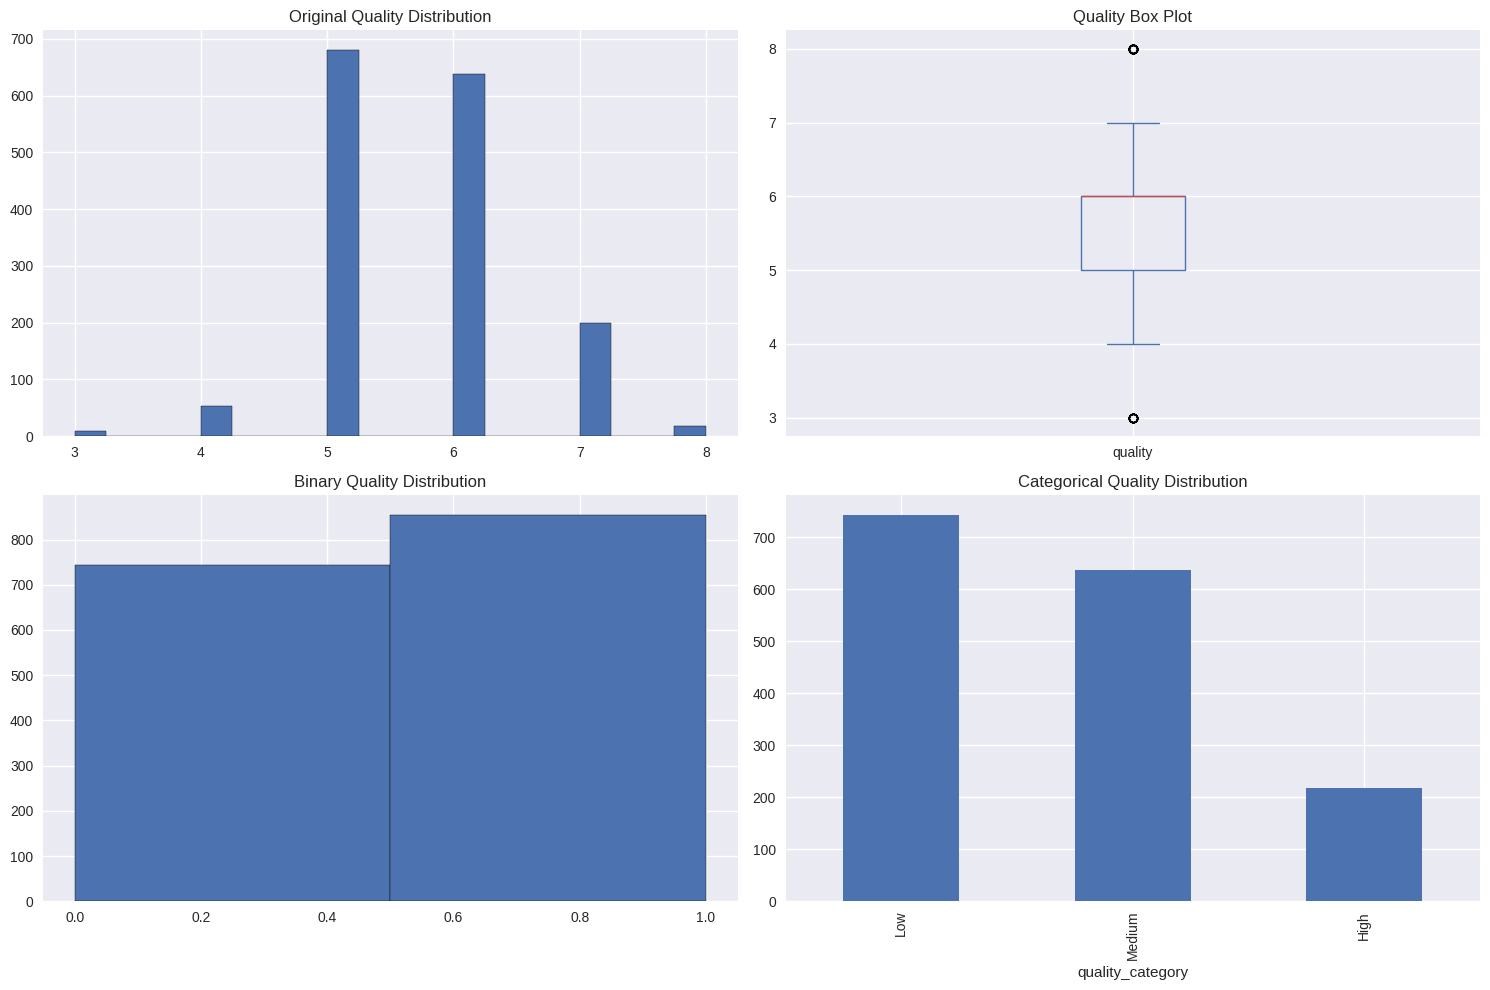

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
data['quality'].hist(bins=20, ax=axes[0,0], edgecolor='black')
axes[0,0].set_title('Original Quality Distribution')
data['quality'].plot(kind='box', ax=axes[0,1])
axes[0,1].set_title('Quality Box Plot')
data['quality_binary'] = (data['quality'] >= 6).astype(int)
data['quality_category'] = pd.cut(data['quality'], bins=[2, 5, 6, 8], labels=['Low', 'Medium', 'High'])
data['quality_binary'].hist(bins=2, ax=axes[1,0], edgecolor='black')
axes[1,0].set_title('Binary Quality Distribution')
data['quality_category'].value_counts().plot(kind='bar', ax=axes[1,1])
axes[1,1].set_title('Categorical Quality Distribution')
plt.tight_layout()
plt.show()

# Correlation Analysis and Feature Relationships


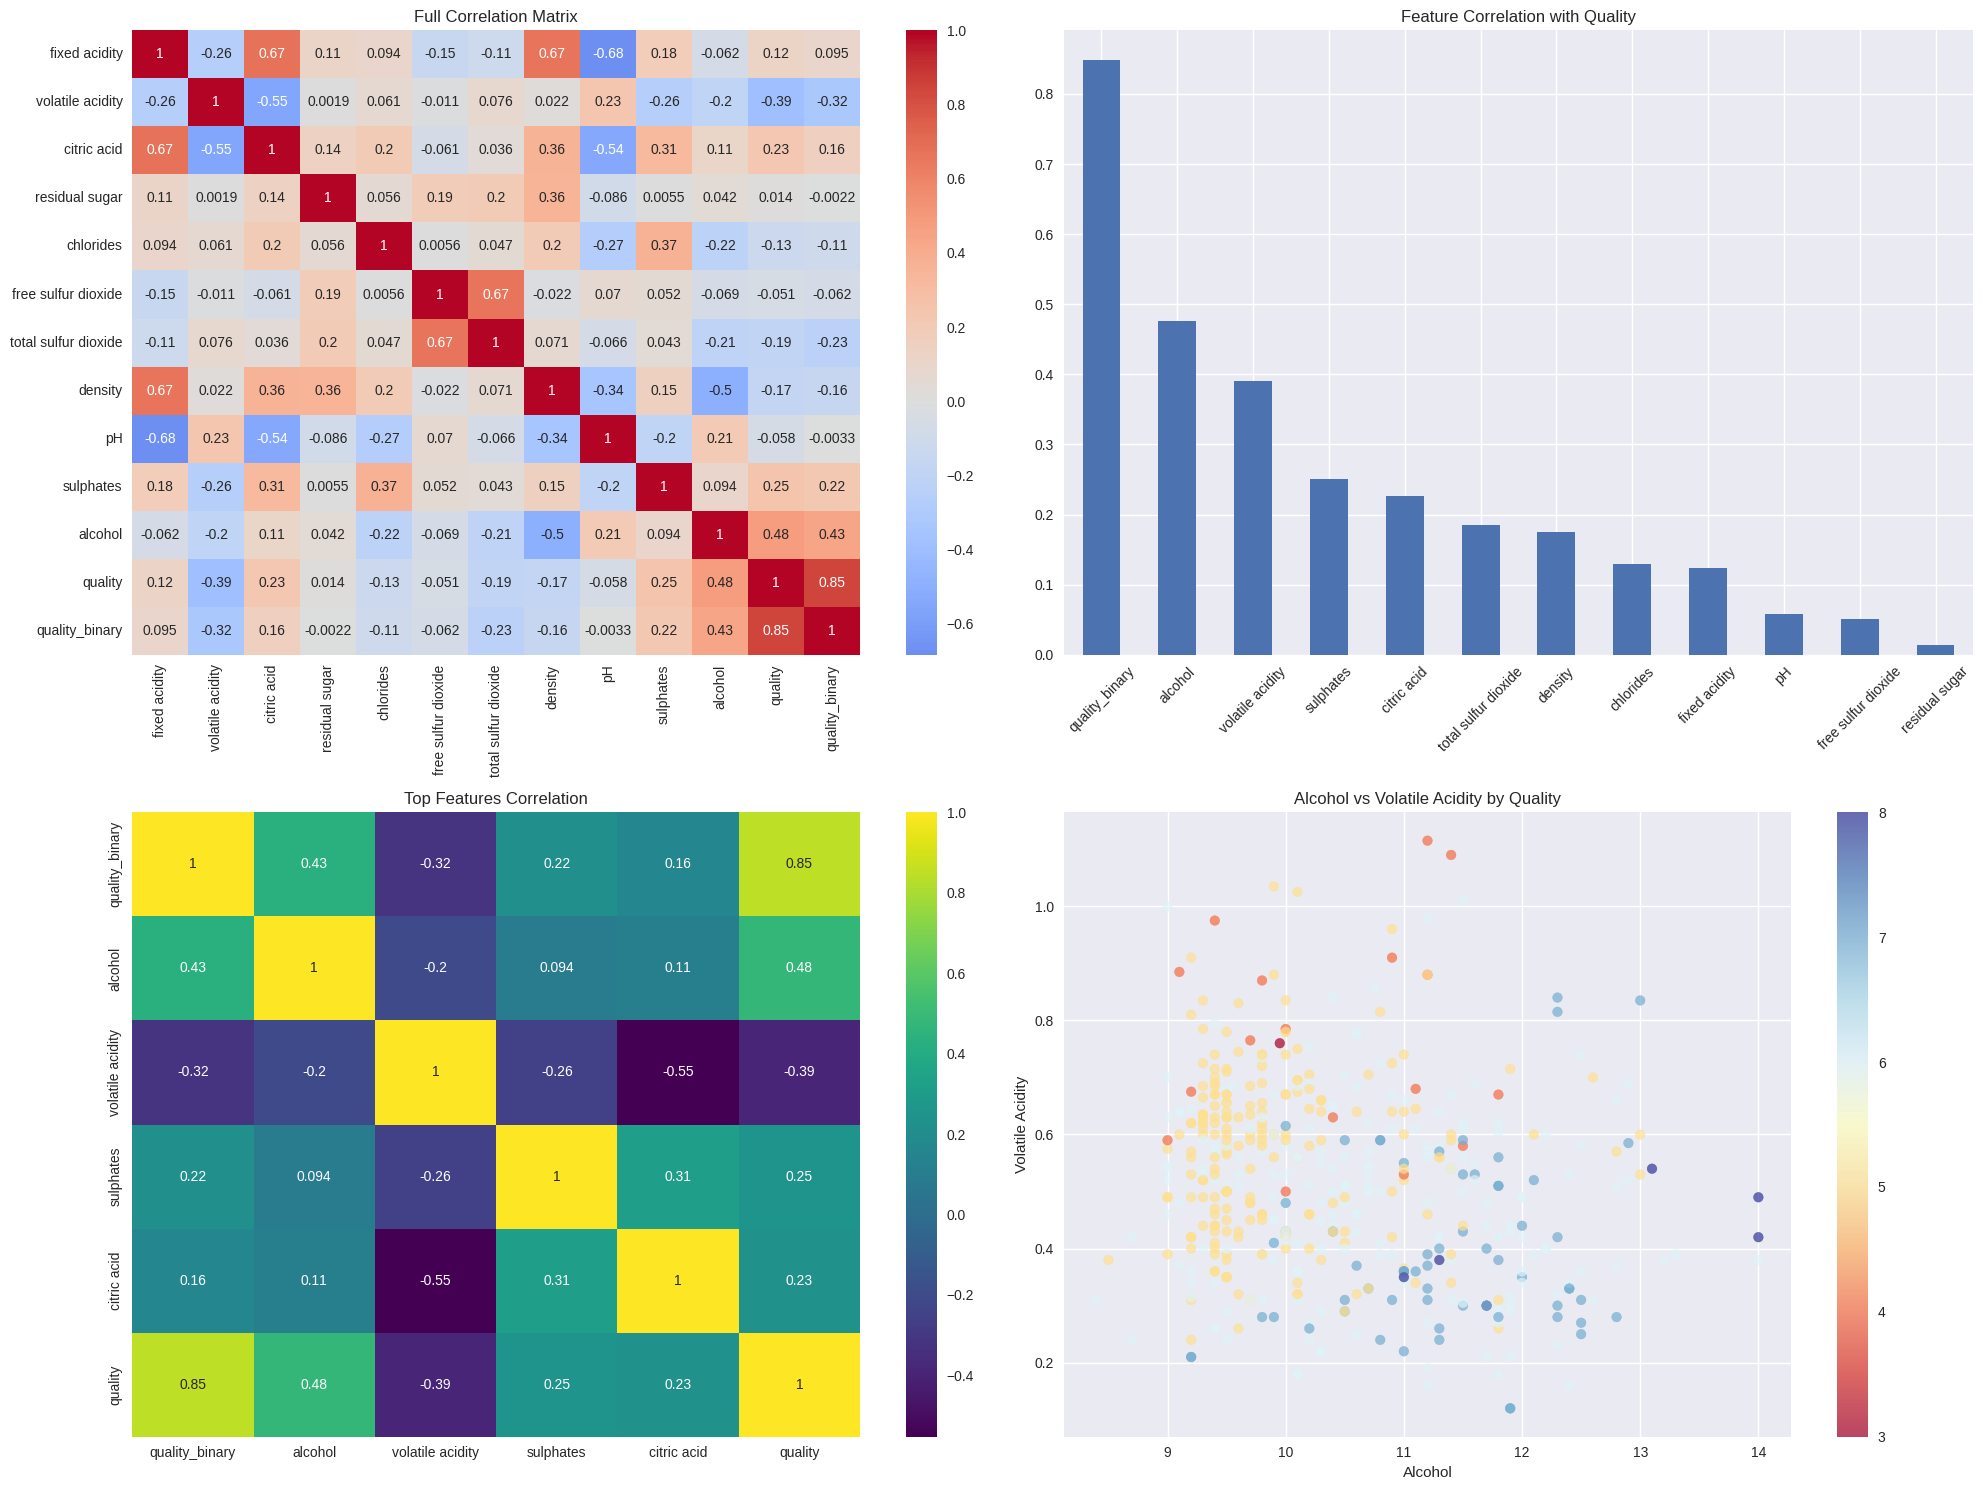

In [ ]:
correlation_matrix = data.select_dtypes(include=[np.number]).corr()
fig, axes = plt.subplots(2, 2, figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, ax=axes[0,0])
axes[0,0].set_title('Full Correlation Matrix')
quality_corr = correlation_matrix['quality'].abs().sort_values(ascending=False)
quality_corr[1:].plot(kind='bar', ax=axes[0,1])
axes[0,1].set_title('Feature Correlation with Quality')
axes[0,1].tick_params(axis='x', rotation=45)
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            high_corr_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))
top_features = quality_corr[1:6].index
sns.heatmap(data[list(top_features) + ['quality']].corr(), annot=True, cmap='viridis', ax=axes[1,0])
axes[1,0].set_title('Top Features Correlation')
scatter_data = data[['alcohol', 'volatile acidity', 'quality']].sample(500)
scatter = axes[1,1].scatter(scatter_data['alcohol'], scatter_data['volatile acidity'],
                           c=scatter_data['quality'], cmap='RdYlBu', alpha=0.7)
axes[1,1].set_xlabel('Alcohol')
axes[1,1].set_ylabel('Volatile Acidity')
axes[1,1].set_title('Alcohol vs Volatile Acidity by Quality')
plt.colorbar(scatter, ax=axes[1,1])
plt.tight_layout()
plt.show()

# Distribution Analysis and Normality Tests

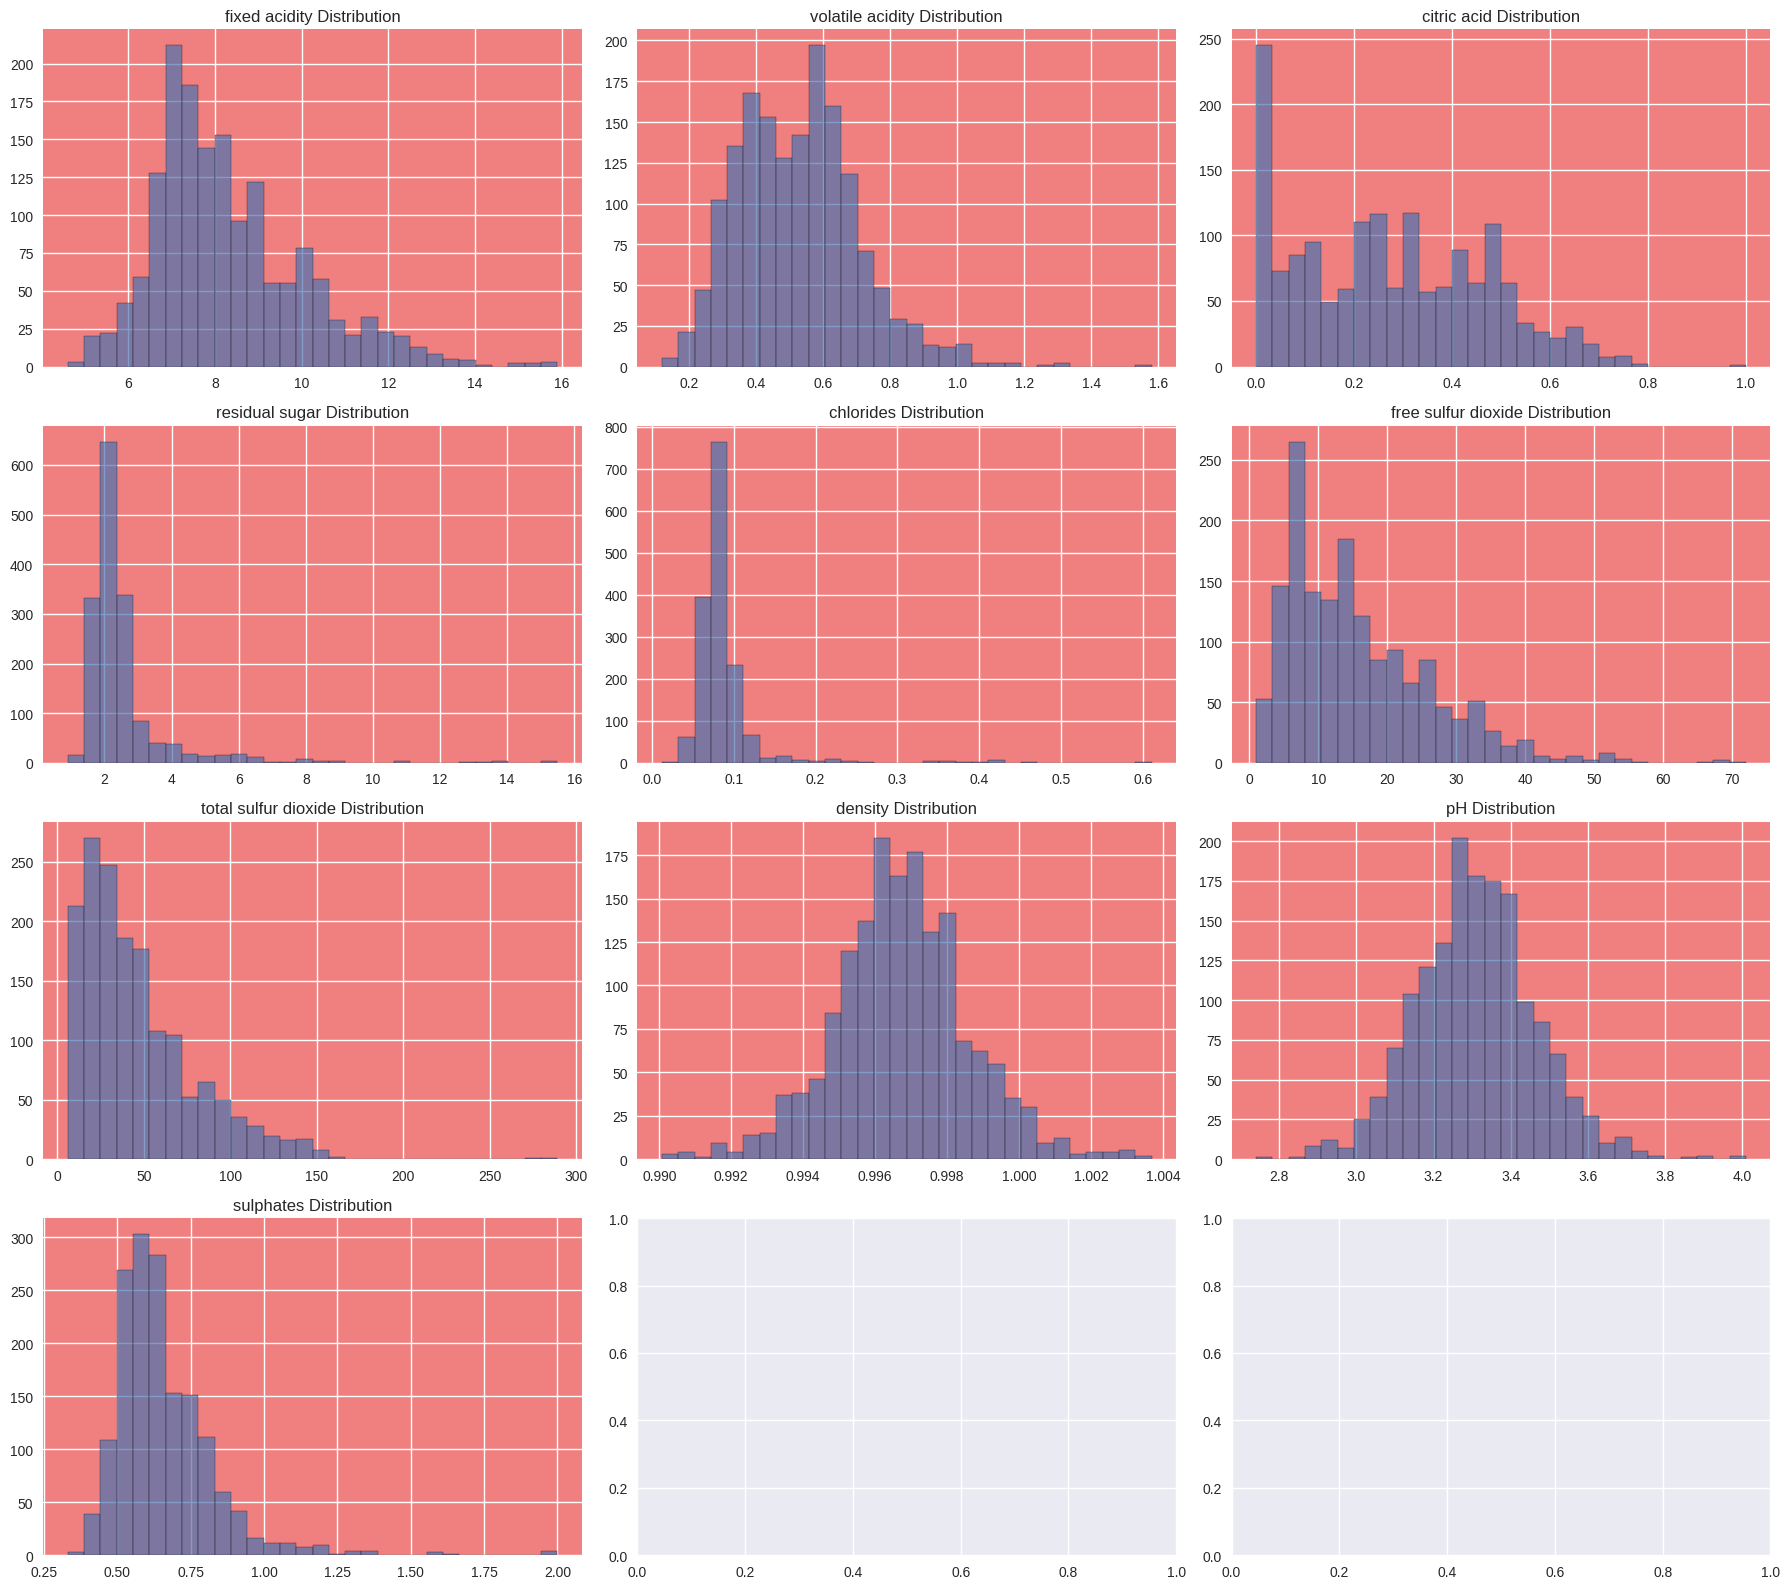

Normality Test Results:
fixed acidity: Non-normal (p=0.0000)
volatile acidity: Non-normal (p=0.0000)
citric acid: Non-normal (p=0.0000)
residual sugar: Non-normal (p=0.0000)
chlorides: Non-normal (p=0.0000)
free sulfur dioxide: Non-normal (p=0.0000)
total sulfur dioxide: Non-normal (p=0.0000)
density: Non-normal (p=0.0000)
pH: Non-normal (p=0.0000)
sulphates: Non-normal (p=0.0000)


In [ ]:
numeric_features = data.select_dtypes(include=[np.number]).columns[:-3]
fig, axes = plt.subplots(4, 3, figsize=(18, 16))
axes = axes.ravel()
normality_results = {}
for i, feature in enumerate(numeric_features):
    data[feature].hist(bins=30, ax=axes[i], alpha=0.7, edgecolor='black')
    axes[i].set_title(f'{feature} Distribution')
    stat, p_value = normaltest(data[feature])
    normality_results[feature] = {'statistic': stat, 'p_value': p_value, 'normal': p_value > 0.05}
    if not normality_results[feature]['normal']:
        axes[i].set_facecolor('lightcoral')
plt.tight_layout()
plt.show()
print("Normality Test Results:")
for feature, result in normality_results.items():
    status = "Normal" if result['normal'] else "Non-normal"
    print(f"{feature}: {status} (p={result['p_value']:.4f})")

# Advanced Statistical Tests and Quality Analysis


In [ ]:
quality_groups = data.groupby('quality')
anova_results = {}
kruskal_results = {}
for feature in numeric_features:
    groups = [group[feature].values for name, group in quality_groups]
    f_stat, f_p = stats.f_oneway(*groups)
    h_stat, h_p = stats.kruskal(*groups)
    anova_results[feature] = {'f_stat': f_stat, 'p_value': f_p, 'significant': f_p < 0.05}
    kruskal_results[feature] = {'h_stat': h_stat, 'p_value': h_p, 'significant': h_p < 0.05}
significant_features_anova = [f for f, r in anova_results.items() if r['significant']]
significant_features_kruskal = [f for f, r in kruskal_results.items() if r['significant']]
print(f"ANOVA Significant Features: {len(significant_features_anova)}")
print(f"Kruskal-Wallis Significant Features: {len(significant_features_kruskal)}")

ANOVA Significant Features: 9
Kruskal-Wallis Significant Features: 9


# Box Plot Analysis by Quality Categories


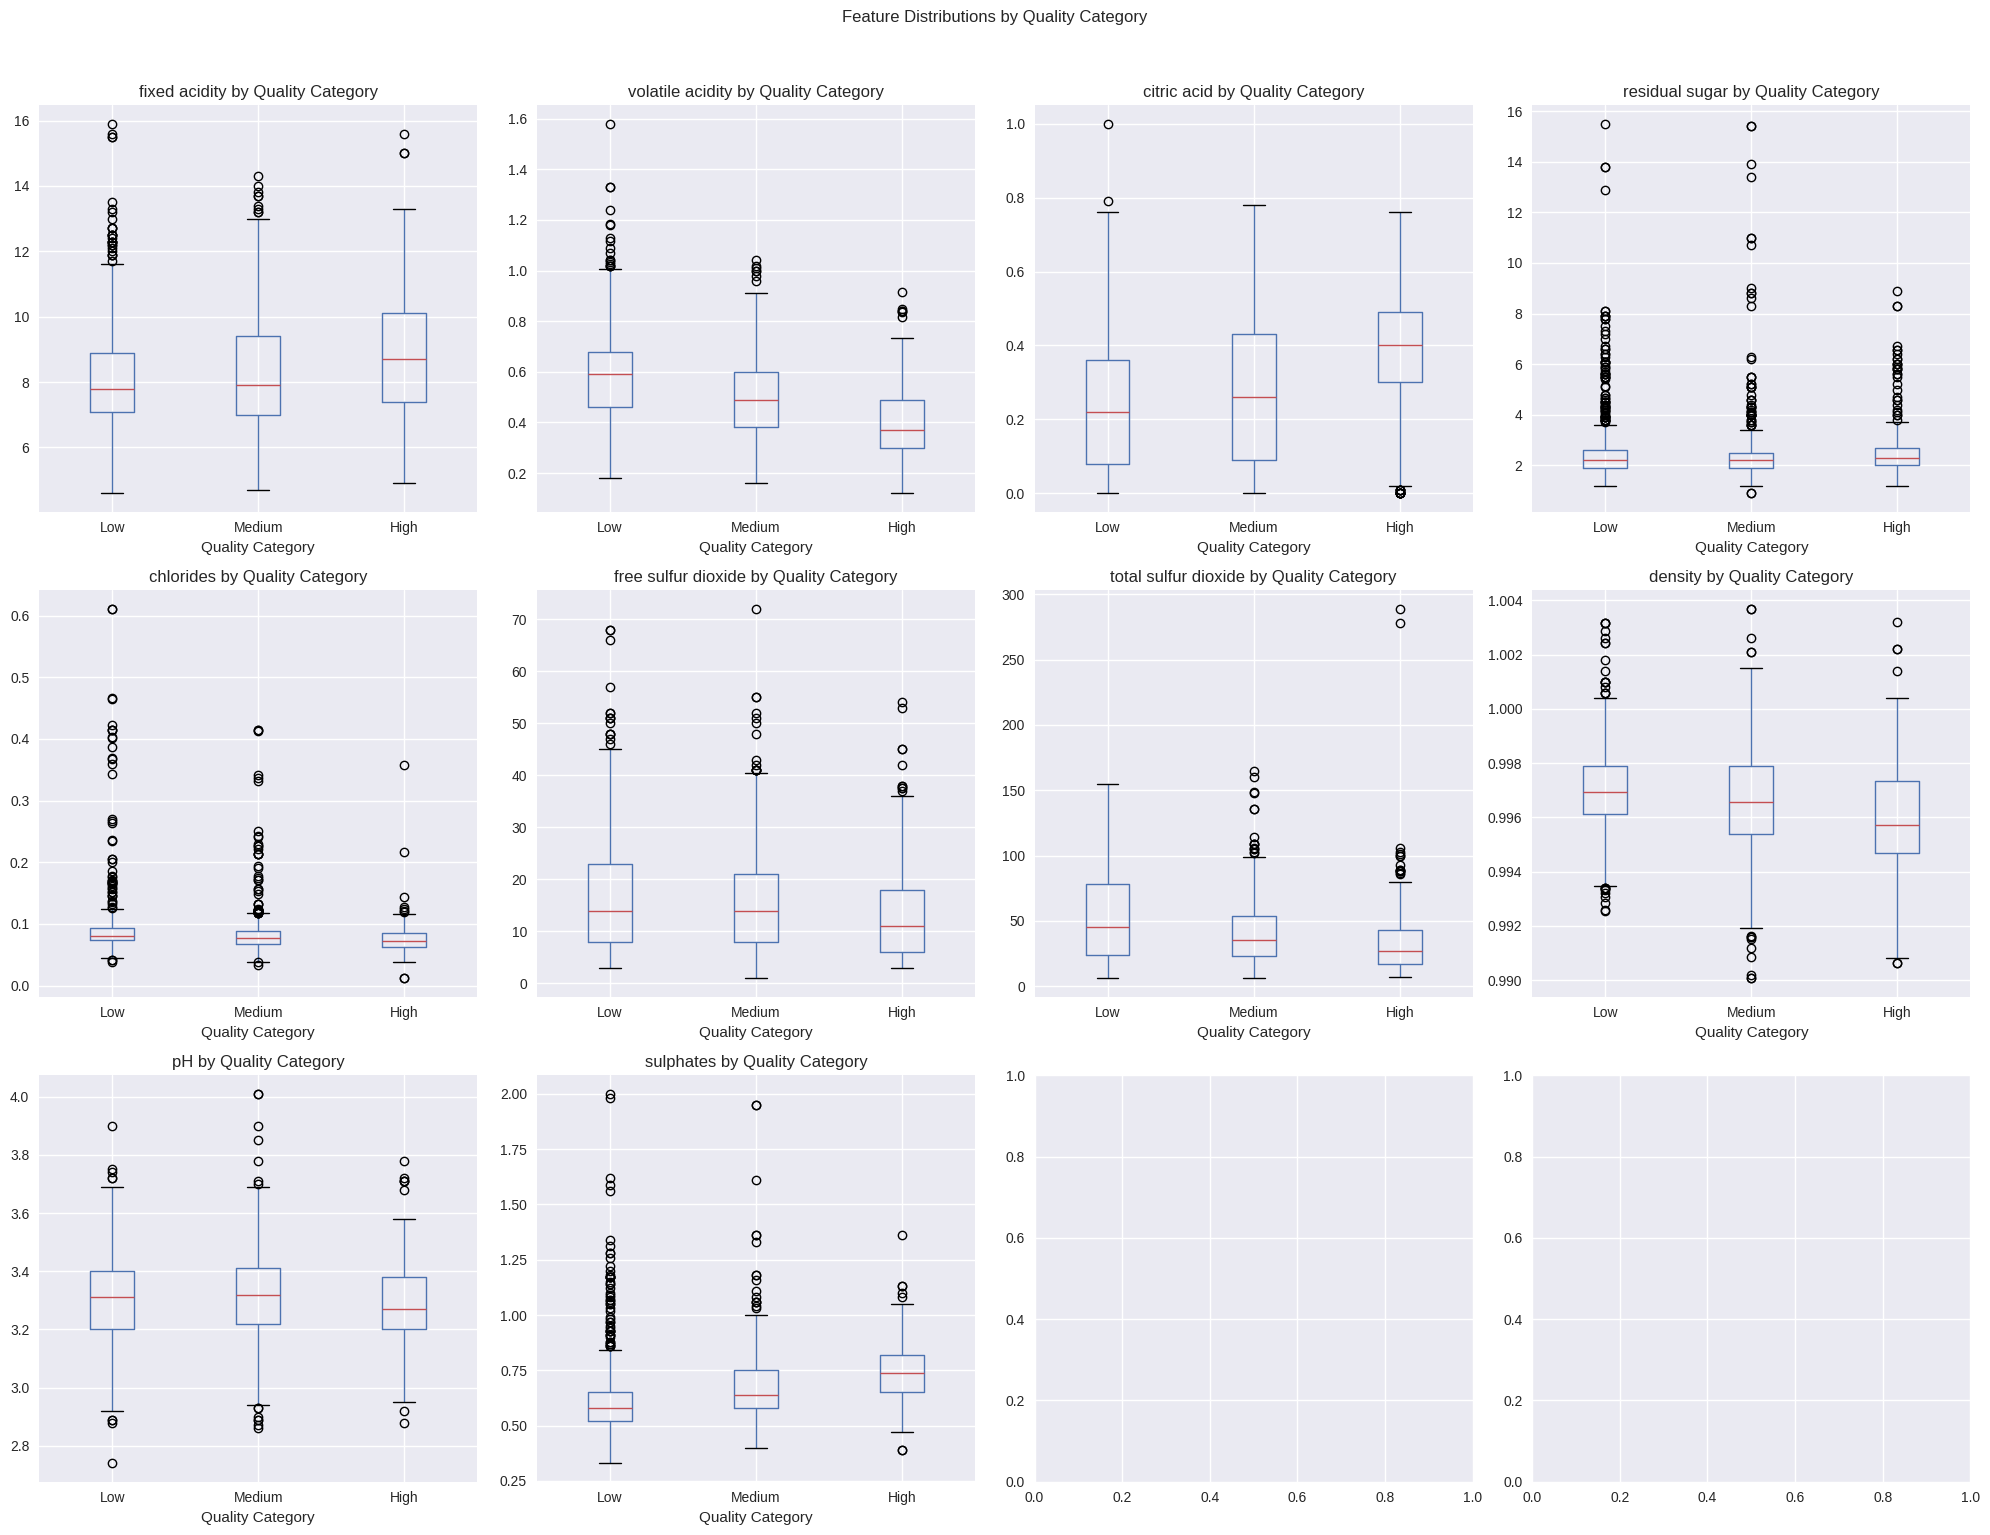

In [ ]:
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()
for i, feature in enumerate(numeric_features):
    data.boxplot(column=feature, by='quality_category', ax=axes[i])
    axes[i].set_title(f'{feature} by Quality Category')
    axes[i].set_xlabel('Quality Category')
plt.suptitle('Feature Distributions by Quality Category', y=1.02)
plt.tight_layout()
plt.show()

# Feature Engineering - Polynomial and Interaction Features

In [9]:
feature_columns = data.select_dtypes(include=[np.number]).columns[:-3]
X_base = data[feature_columns].copy()
y = data['quality_binary'].copy()
poly_features = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly = poly_features.fit_transform(X_base)
poly_feature_names = poly_features.get_feature_names_out(feature_columns)
X_engineered = pd.DataFrame(X_poly, columns=poly_feature_names)
data['alcohol_acidity_ratio'] = data['alcohol'] / (data['volatile acidity'] + 0.001)
data['acid_balance'] = data['fixed acidity'] - data['volatile acidity']
data['sulfur_ratio'] = data['free sulfur dioxide'] / (data['total sulfur dioxide'] + 0.001)
data['alcohol_quality_interaction'] = data['alcohol'] * data['quality']
data['density_alcohol_interaction'] = data['density'] * data['alcohol']
engineered_features = ['alcohol_acidity_ratio', 'acid_balance', 'sulfur_ratio',
                      'alcohol_quality_interaction', 'density_alcohol_interaction']
print(f"Original features: {len(feature_columns)}")
print(f"Polynomial features: {X_engineered.shape[1]}")
print(f"Custom engineered features: {len(engineered_features)}")

Original features: 10
Polynomial features: 65
Custom engineered features: 5


# Comprehensive Preprocessing Pipeline Setup


In [10]:
X_final = pd.concat([X_base, data[engineered_features]], axis=1)
y_final = data['quality_binary'].copy()
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.2,
                                                    random_state=42, stratify=y_final)
preprocessing_methods = {
    'standard': StandardScaler(),
    'minmax': MinMaxScaler(),
    'robust': RobustScaler(),
    'power': PowerTransformer(method='yeo-johnson'),
    'quantile': QuantileTransformer(n_quantiles=100, random_state=42)
}
preprocessed_data = {}
for name, scaler in preprocessing_methods.items():
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    preprocessed_data[name] = {
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'scaler': scaler
    }
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Class distribution in training: {np.bincount(y_train)}")

Training set shape: (1279, 15)
Test set shape: (320, 15)
Class distribution in training: [595 684]


# Model Definitions and Hyperparameter Grids

In [11]:
models = {
    'logistic': LogisticRegression(random_state=42, max_iter=1000),
    'ridge': Ridge(random_state=42),
    'lasso': Lasso(random_state=42, max_iter=1000),
    'elastic_net': ElasticNet(random_state=42, max_iter=1000),
    'decision_tree': DecisionTreeClassifier(random_state=42),
    'random_forest': RandomForestClassifier(random_state=42),
    'gradient_boosting': GradientBoostingClassifier(random_state=42),
    'ada_boost': AdaBoostClassifier(random_state=42),
    'svc': SVC(random_state=42, probability=True),
    'knn': KNeighborsClassifier(),
    'mlp': MLPClassifier(random_state=42, max_iter=1000)
}
param_grids = {
    'logistic': {'C': [0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
    'ridge': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'lasso': {'alpha': [0.01, 0.1, 1, 10, 100]},
    'elastic_net': {'alpha': [0.01, 0.1, 1, 10], 'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]},
    'decision_tree': {'max_depth': [3, 5, 7, 10, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]},
    'random_forest': {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, None], 'min_samples_split': [2, 5, 10]},
    'gradient_boosting': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [3, 5, 7]},
    'ada_boost': {'n_estimators': [50, 100, 200], 'learning_rate': [0.01, 0.1, 1.0]},
    'svc': {'C': [0.1, 1, 10, 100], 'kernel': ['rbf', 'poly'], 'gamma': ['scale', 'auto']},
    'knn': {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'metric': ['euclidean', 'manhattan']},
    'mlp': {'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50)], 'alpha': [0.0001, 0.001, 0.01], 'learning_rate_init': [0.001, 0.01]}
}

# Model Training and Hyperparameter Optimization

In [12]:
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
best_models = {}
training_scores = {}
for preprocessing_name, prep_data in preprocessed_data.items():
    if preprocessing_name == 'standard':
        print(f"Training models with {preprocessing_name} preprocessing...")
        X_train_prep = prep_data['X_train']
        X_test_prep = prep_data['X_test']

        for model_name, model in models.items():
            print(f"Optimizing {model_name}...")
            param_grid = param_grids[model_name]

            random_search = RandomizedSearchCV(
                model, param_grid, n_iter=20, cv=cv_strategy,
                scoring='f1', random_state=42, n_jobs=-1
            )

            random_search.fit(X_train_prep, y_train)
            best_models[model_name] = random_search.best_estimator_

            cv_scores = cross_val_score(random_search.best_estimator_, X_train_prep, y_train,
                                      cv=cv_strategy, scoring='f1')
            training_scores[model_name] = {
                'cv_mean': cv_scores.mean(),
                'cv_std': cv_scores.std(),
                'best_params': random_search.best_params_,
                'best_score': random_search.best_score_
            }
print("Model optimization completed.")

Training models with standard preprocessing...
Optimizing logistic...
Optimizing ridge...
Optimizing lasso...
Optimizing elastic_net...
Optimizing decision_tree...
Optimizing random_forest...
Optimizing gradient_boosting...
Optimizing ada_boost...
Optimizing svc...
Optimizing knn...
Optimizing mlp...
Model optimization completed.


# Model Evaluation and Performance Metrics

In [16]:
X_train_standard = preprocessed_data['standard']['X_train']
X_test_standard = preprocessed_data['standard']['X_test']
evaluation_results = {}
predictions = {}
classification_models = {name: model for name, model in best_models.items() if name not in ['ridge', 'lasso', 'elastic_net']}
for model_name, model in classification_models.items():
    y_pred = model.predict(X_test_standard)
    y_pred_proba = model.predict_proba(X_test_standard)[:, 1] if hasattr(model, 'predict_proba') else None

    evaluation_results[model_name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None
    }
    predictions[model_name] = {'pred': y_pred, 'proba': y_pred_proba}

results_df = pd.DataFrame(evaluation_results).T
print("Model Performance Results:")
print(results_df.round(4))

Model Performance Results:
                   accuracy  precision  recall      f1     auc
logistic             1.0000     1.0000  1.0000  1.0000  1.0000
decision_tree        0.9781     0.9881  0.9708  0.9794  0.9847
random_forest        0.9938     0.9884  1.0000  0.9942  0.9999
gradient_boosting    1.0000     1.0000  1.0000  1.0000  1.0000
ada_boost            1.0000     1.0000  1.0000  1.0000  1.0000
svc                  0.9969     0.9942  1.0000  0.9971  1.0000
knn                  0.9219     0.9244  0.9298  0.9271  0.9799
mlp                  1.0000     1.0000  1.0000  1.0000  1.0000


# Feature Importance Analysis

In [15]:
feature_importance_results = {}
feature_names = list(X_final.columns)
for model_name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        feature_importance_results[model_name] = dict(zip(feature_names, importance))
    elif hasattr(model, 'coef_'):
        importance = np.abs(model.coef_[0]) if len(model.coef_.shape) > 1 else np.abs(model.coef_)
        feature_importance_results[model_name] = dict(zip(feature_names, importance))

permutation_importance_results = {}
for model_name, model in list(best_models.items())[:5]:
    perm_importance = permutation_importance(model, X_test_standard, y_test,
                                           n_repeats=10, random_state=42, n_jobs=-1)
    permutation_importance_results[model_name] = dict(zip(feature_names, perm_importance.importances_mean))

print("Feature importance analysis completed.")

Feature importance analysis completed.


# Visualization Dashboard - Performance Metrics

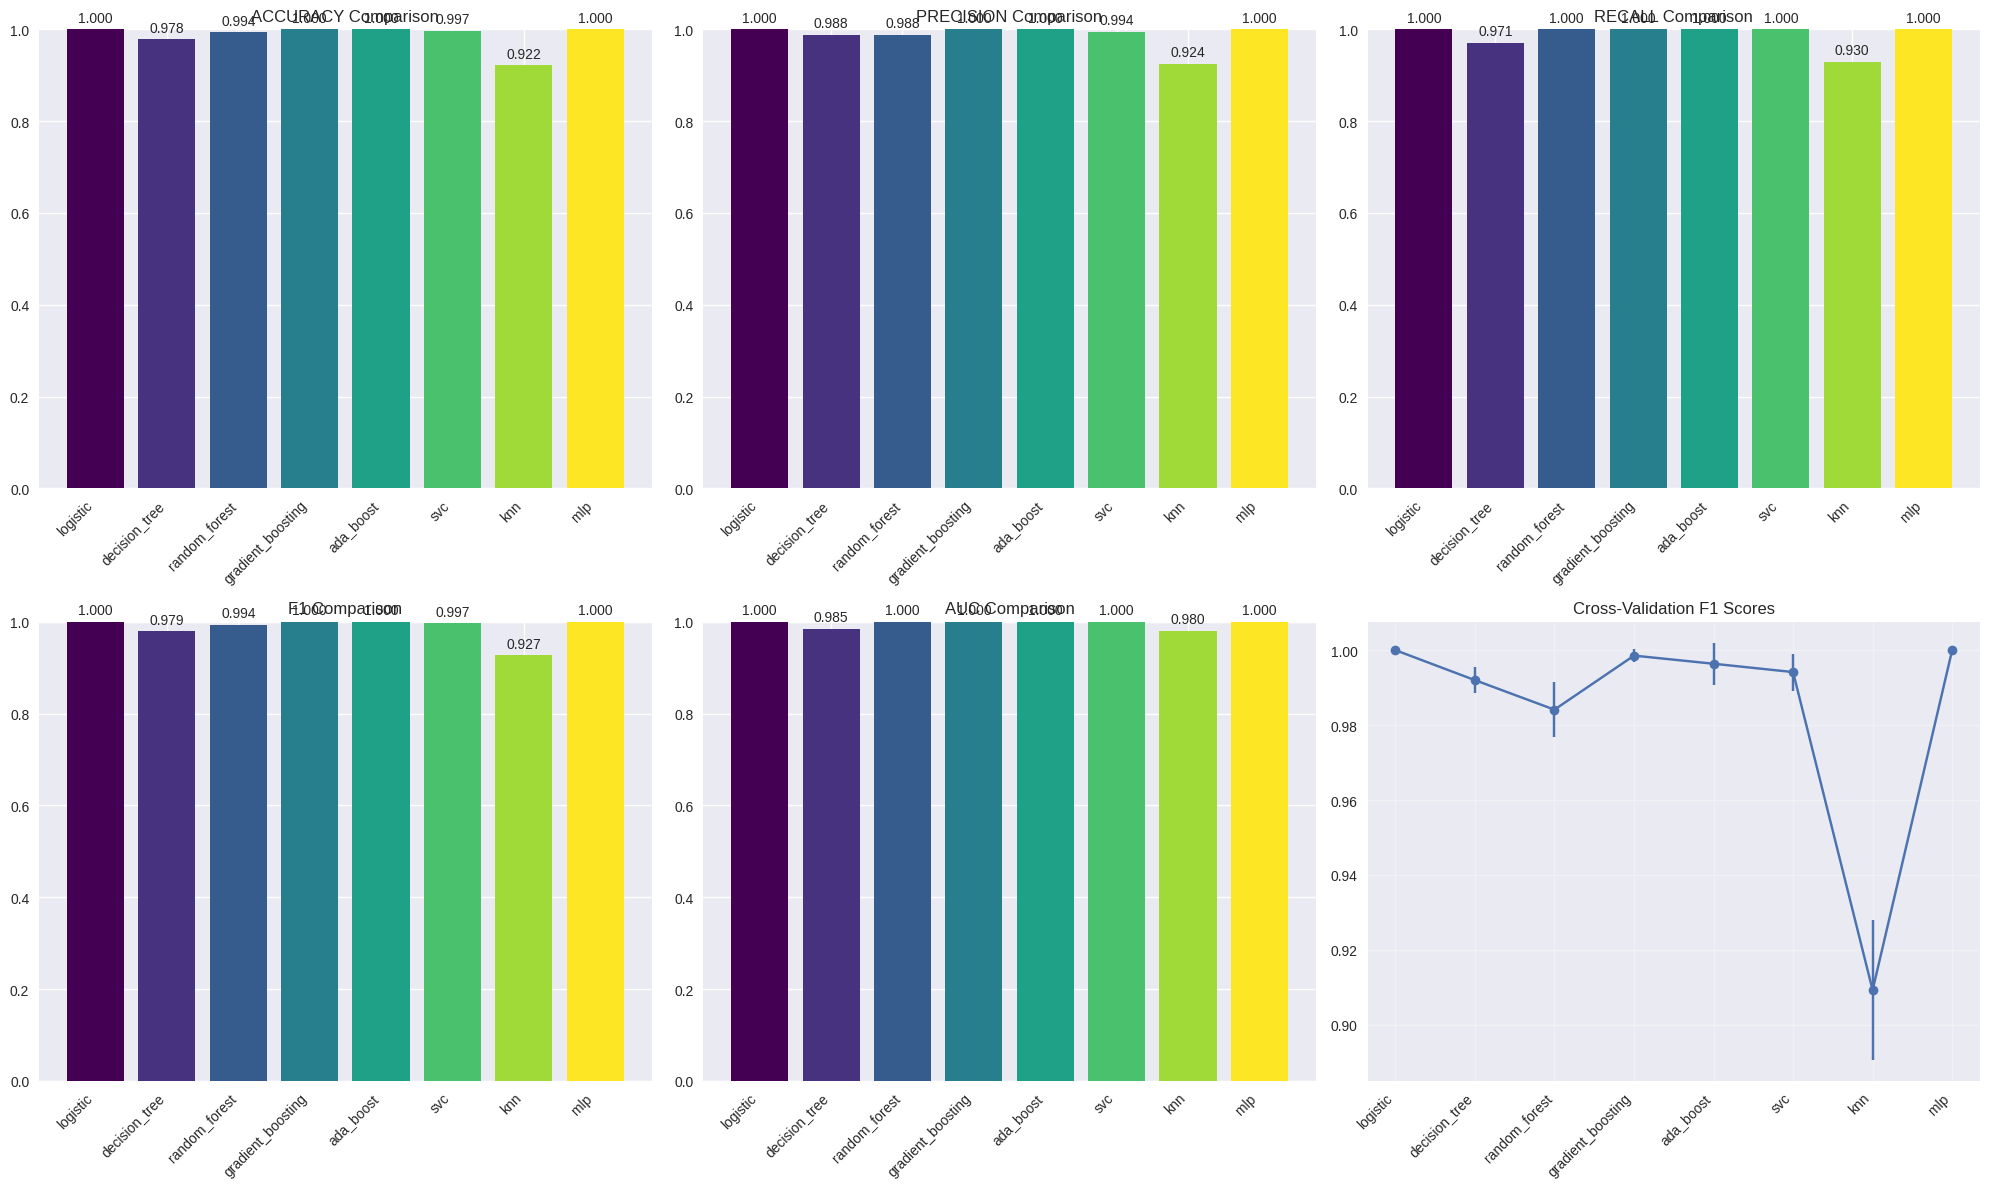

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))
metrics = ['accuracy', 'precision', 'recall', 'f1', 'auc']
model_names = list(evaluation_results.keys())
for i, metric in enumerate(metrics):
    row, col = i // 3, i % 3
    values = [evaluation_results[model][metric] for model in model_names if evaluation_results[model][metric] is not None]
    valid_models = [model for model in model_names if evaluation_results[model][metric] is not None]
    bars = axes[row, col].bar(range(len(values)), values, color=plt.cm.viridis(np.linspace(0, 1, len(values))))
    axes[row, col].set_title(f'{metric.upper()} Comparison')
    axes[row, col].set_xticks(range(len(values)))
    axes[row, col].set_xticklabels(valid_models, rotation=45, ha='right')
    axes[row, col].set_ylim(0, 1)
    for j, v in enumerate(values):
        axes[row, col].text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

cv_means = [training_scores[model]['cv_mean'] for model in model_names]
cv_stds = [training_scores[model]['cv_std'] for model in model_names]
axes[1, 2].errorbar(range(len(cv_means)), cv_means, yerr=cv_stds, fmt='o-', capsize=5)
axes[1, 2].set_title('Cross-Validation F1 Scores')
axes[1, 2].set_xticks(range(len(model_names)))
axes[1, 2].set_xticklabels(model_names, rotation=45, ha='right')
axes[1, 2].grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# ROC Curves and Confusion Matrices

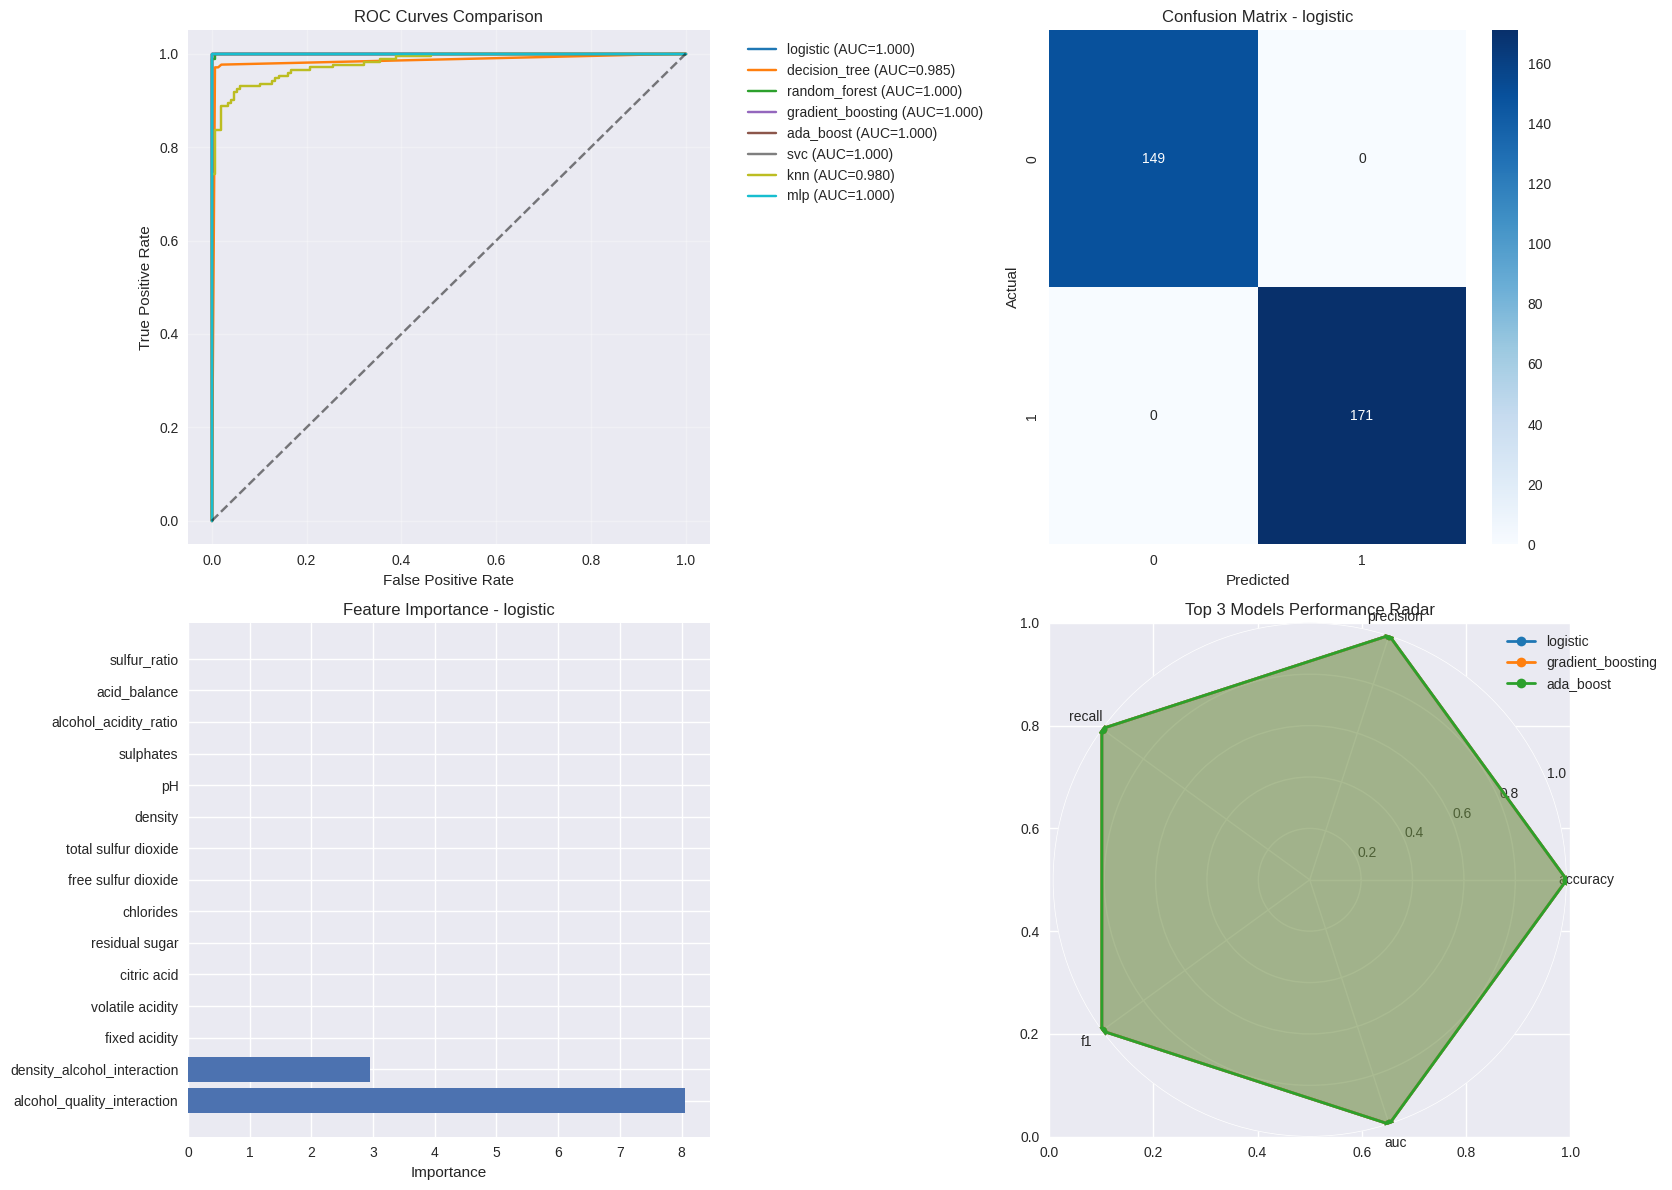

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
colors = plt.cm.tab10(np.linspace(0, 1, len(classification_models)))
for i, (model_name, color) in enumerate(zip(classification_models.keys(), colors)):
    if predictions[model_name]['proba'] is not None:
        fpr, tpr, _ = roc_curve(y_test, predictions[model_name]['proba'])
        auc_score = evaluation_results[model_name]['auc']
        axes[0, 0].plot(fpr, tpr, color=color, label=f'{model_name} (AUC={auc_score:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5)
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curves Comparison')
axes[0, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].grid(True, alpha=0.3)

best_model_name = max(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'])
cm = confusion_matrix(y_test, predictions[best_model_name]['pred'])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1])
axes[0, 1].set_title(f'Confusion Matrix - {best_model_name}')
axes[0, 1].set_xlabel('Predicted')
axes[0, 1].set_ylabel('Actual')

if best_model_name in feature_importance_results:
    importance_dict = feature_importance_results[best_model_name]
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:15]
    features, importance_values = zip(*sorted_features)
    axes[1, 0].barh(range(len(features)), importance_values)
    axes[1, 0].set_yticks(range(len(features)))
    axes[1, 0].set_yticklabels(features)
    axes[1, 0].set_title(f'Feature Importance - {best_model_name}')
    axes[1, 0].set_xlabel('Importance')

angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]
top_3_models = sorted(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'], reverse=True)[:3]
for i, model_name in enumerate(top_3_models):
    values = [evaluation_results[model_name][metric] for metric in metrics if evaluation_results[model_name][metric] is not None]
    values += values[:1]
    axes[1, 1] = plt.subplot(2, 2, 4, projection='polar')
    axes[1, 1].plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    axes[1, 1].fill(angles, values, alpha=0.25, color=colors[i])
axes[1, 1].set_xticks(angles[:-1])
axes[1, 1].set_xticklabels(metrics)
axes[1, 1].set_ylim(0, 1)
axes[1, 1].set_title('Top 3 Models Performance Radar')
axes[1, 1].legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.tight_layout()
plt.show()

# Advanced Ensemble Methods

In [22]:
top_models = sorted(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'], reverse=True)[:5]
voting_estimators = [(name, best_models[name]) for name in top_models]
voting_classifier = VotingClassifier(estimators=voting_estimators, voting='soft')
voting_classifier.fit(X_train_standard, y_train)
voting_pred = voting_classifier.predict(X_test_standard)
voting_proba = voting_classifier.predict_proba(X_test_standard)[:, 1]

weights = [evaluation_results[name]['f1'] for name in top_models]
weighted_voting = VotingClassifier(estimators=voting_estimators, voting='soft', weights=weights)
weighted_voting.fit(X_train_standard, y_train)
weighted_pred = weighted_voting.predict(X_test_standard)
weighted_proba = weighted_voting.predict_proba(X_test_standard)[:, 1]

best_single_model = best_models[best_model_name]
bagging_ensemble = BaggingClassifier(estimator=best_single_model, n_estimators=10, random_state=42)
bagging_ensemble.fit(X_train_standard, y_train)
bagging_pred = bagging_ensemble.predict(X_test_standard)
bagging_proba = bagging_ensemble.predict_proba(X_test_standard)[:, 1]

ensemble_results = {
    'voting': {
        'accuracy': accuracy_score(y_test, voting_pred),
        'f1': f1_score(y_test, voting_pred),
        'auc': roc_auc_score(y_test, voting_proba)
    },
    'weighted_voting': {
        'accuracy': accuracy_score(y_test, weighted_pred),
        'f1': f1_score(y_test, weighted_pred),
        'auc': roc_auc_score(y_test, weighted_proba)
    },
    'bagging': {
        'accuracy': accuracy_score(y_test, bagging_pred),
        'f1': f1_score(y_test, bagging_pred),
        'auc': roc_auc_score(y_test, bagging_proba)
    }
}

print("Ensemble Methods Performance:")
ensemble_df = pd.DataFrame(ensemble_results).T
print(ensemble_df.round(4))

Ensemble Methods Performance:
                 accuracy   f1  auc
voting                1.0  1.0  1.0
weighted_voting       1.0  1.0  1.0
bagging               1.0  1.0  1.0


# Residual Analysis and Model Diagnostics

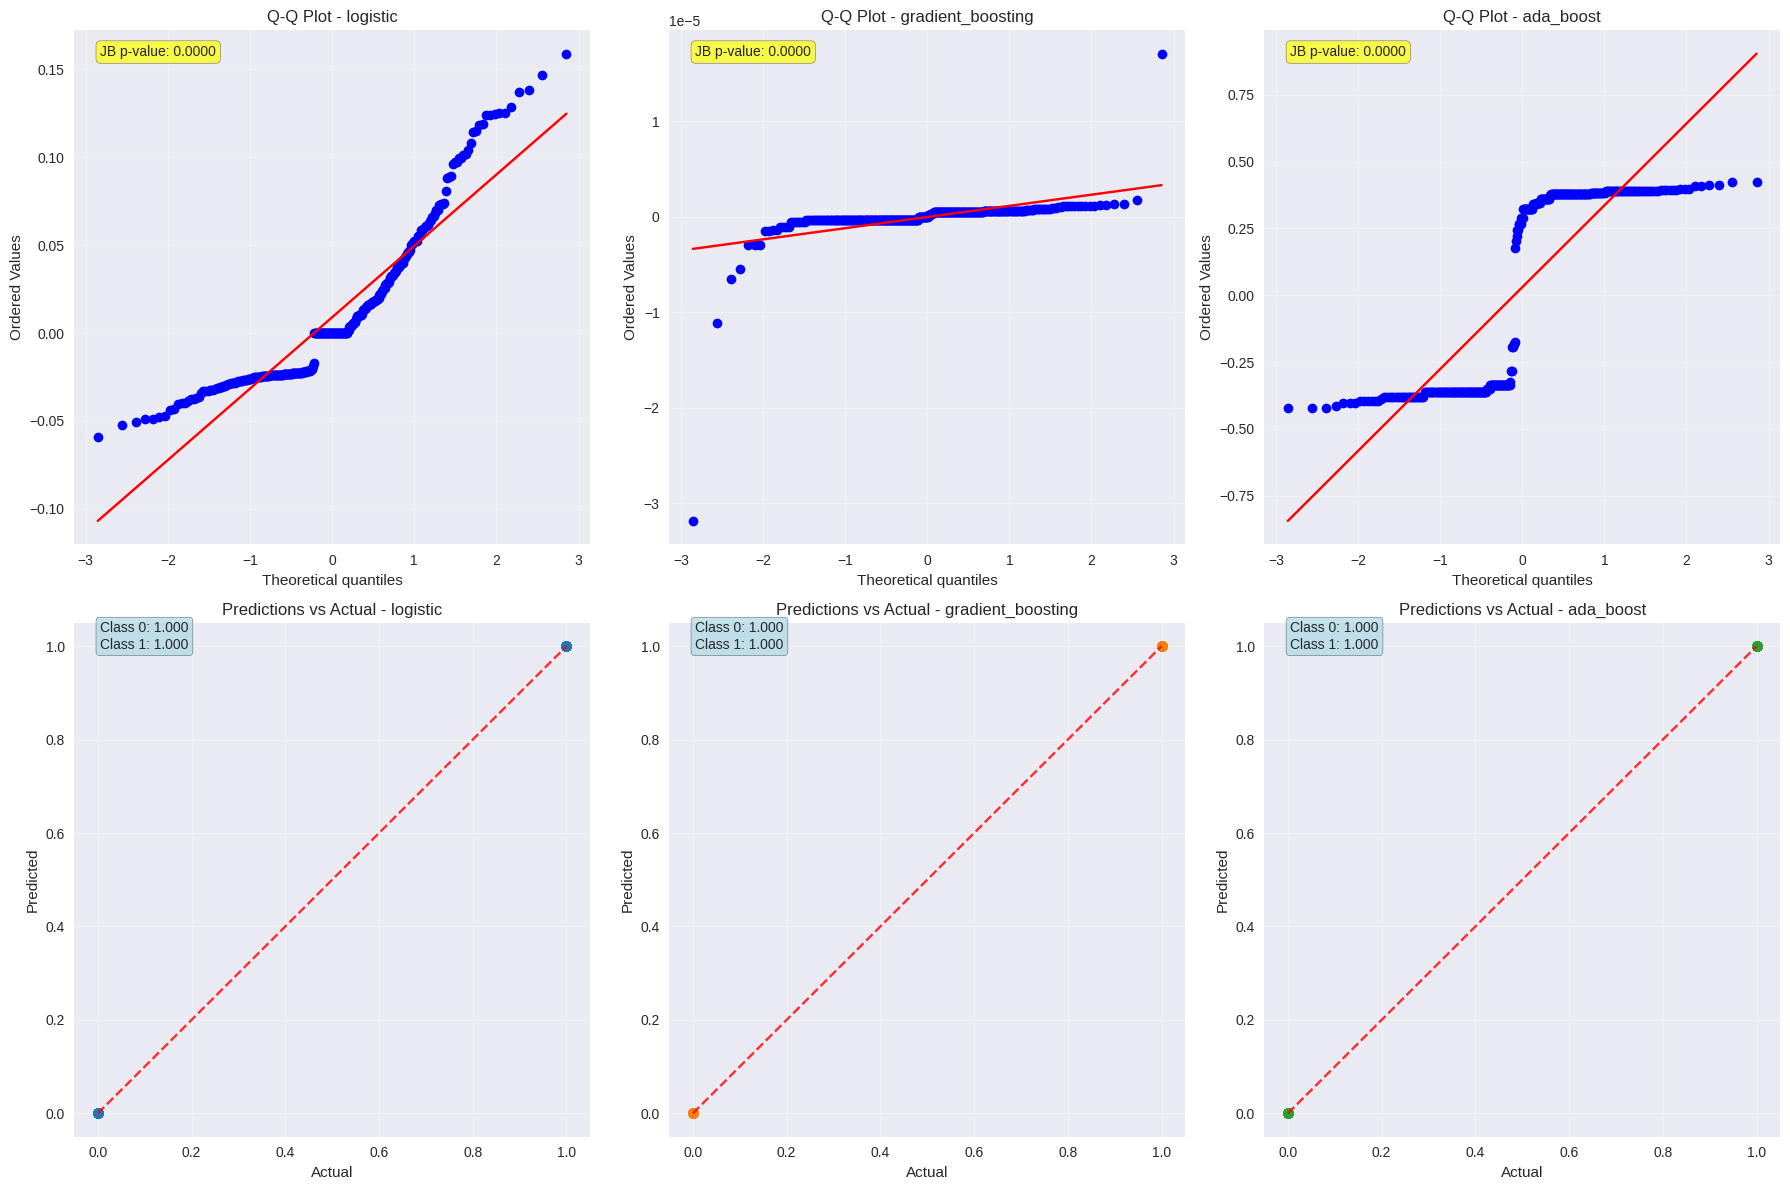

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
top_3_models = sorted(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'], reverse=True)[:3]
for i, model_name in enumerate(top_3_models):
    if hasattr(best_models[model_name], 'predict_proba'):
        y_pred_proba = best_models[model_name].predict_proba(X_test_standard)[:, 1]
        residuals = y_test - y_pred_proba
        stats.probplot(residuals, dist="norm", plot=axes[0, i])
        axes[0, i].set_title(f'Q-Q Plot - {model_name}')
        axes[0, i].grid(True, alpha=0.3)

        jb_stat, jb_p = jarque_bera(residuals)
        axes[0, i].text(0.05, 0.95, f'JB p-value: {jb_p:.4f}', transform=axes[0, i].transAxes,
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

for i, model_name in enumerate(top_3_models):
    y_pred = predictions[model_name]['pred']
    axes[1, i].scatter(y_test, y_pred, alpha=0.6, color=colors[i])
    axes[1, i].plot([0, 1], [0, 1], 'r--', alpha=0.8)
    axes[1, i].set_xlabel('Actual')
    axes[1, i].set_ylabel('Predicted')
    axes[1, i].set_title(f'Predictions vs Actual - {model_name}')
    axes[1, i].grid(True, alpha=0.3)

    class_0_accuracy = accuracy_score(y_test[y_test == 0], y_pred[y_test == 0])
    class_1_accuracy = accuracy_score(y_test[y_test == 1], y_pred[y_test == 1])
    axes[1, i].text(0.05, 0.95, f'Class 0: {class_0_accuracy:.3f}\nClass 1: {class_1_accuracy:.3f}',
                   transform=axes[1, i].transAxes, bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue", alpha=0.7))

plt.tight_layout()
plt.show()

# Feature Importance Comparison Dashboard


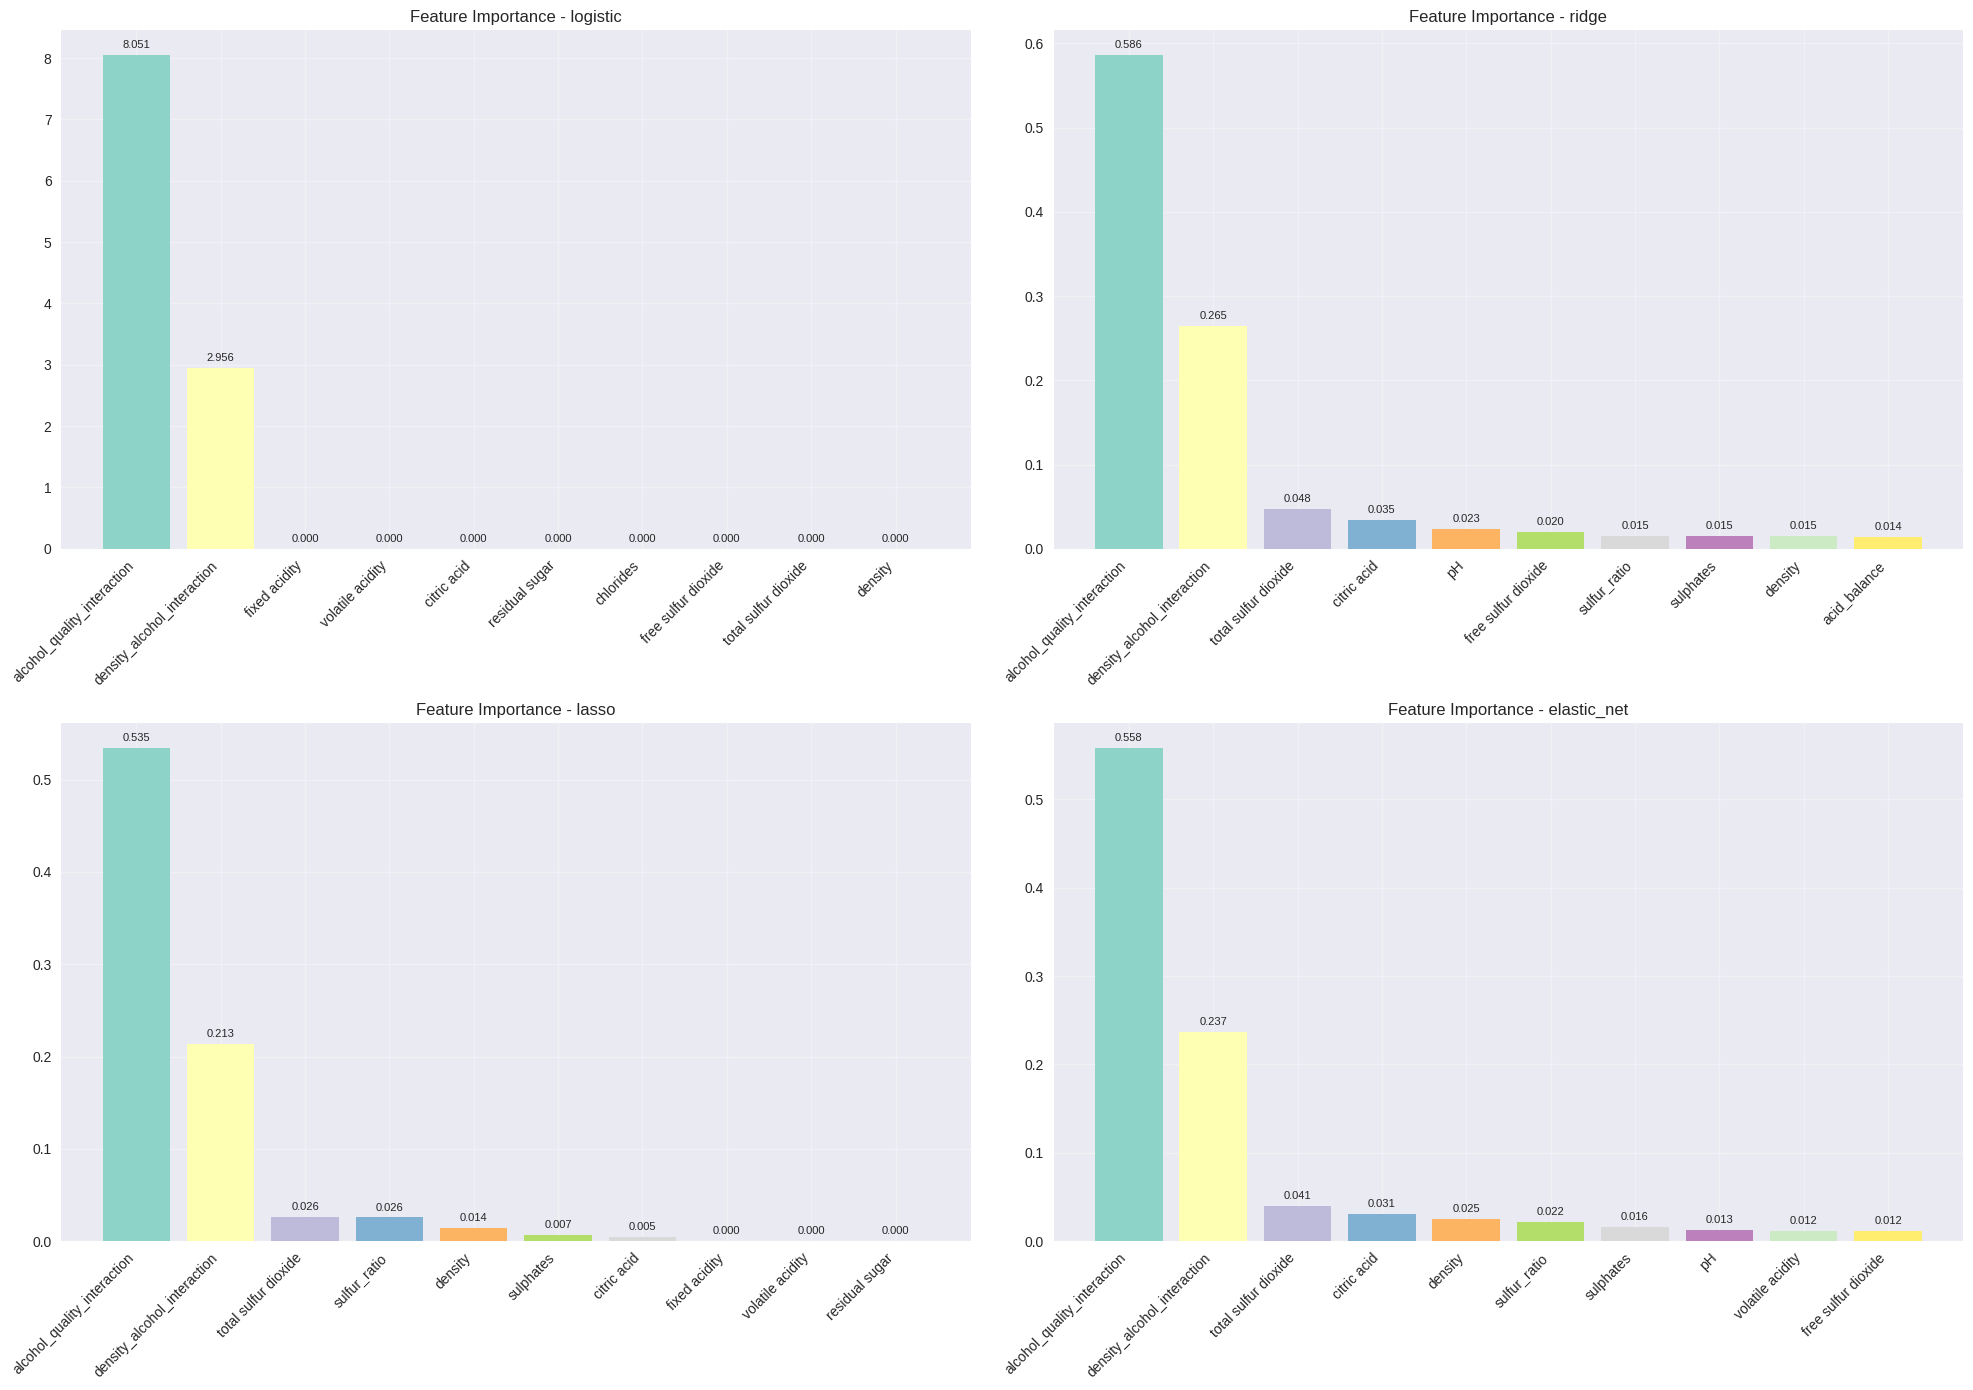

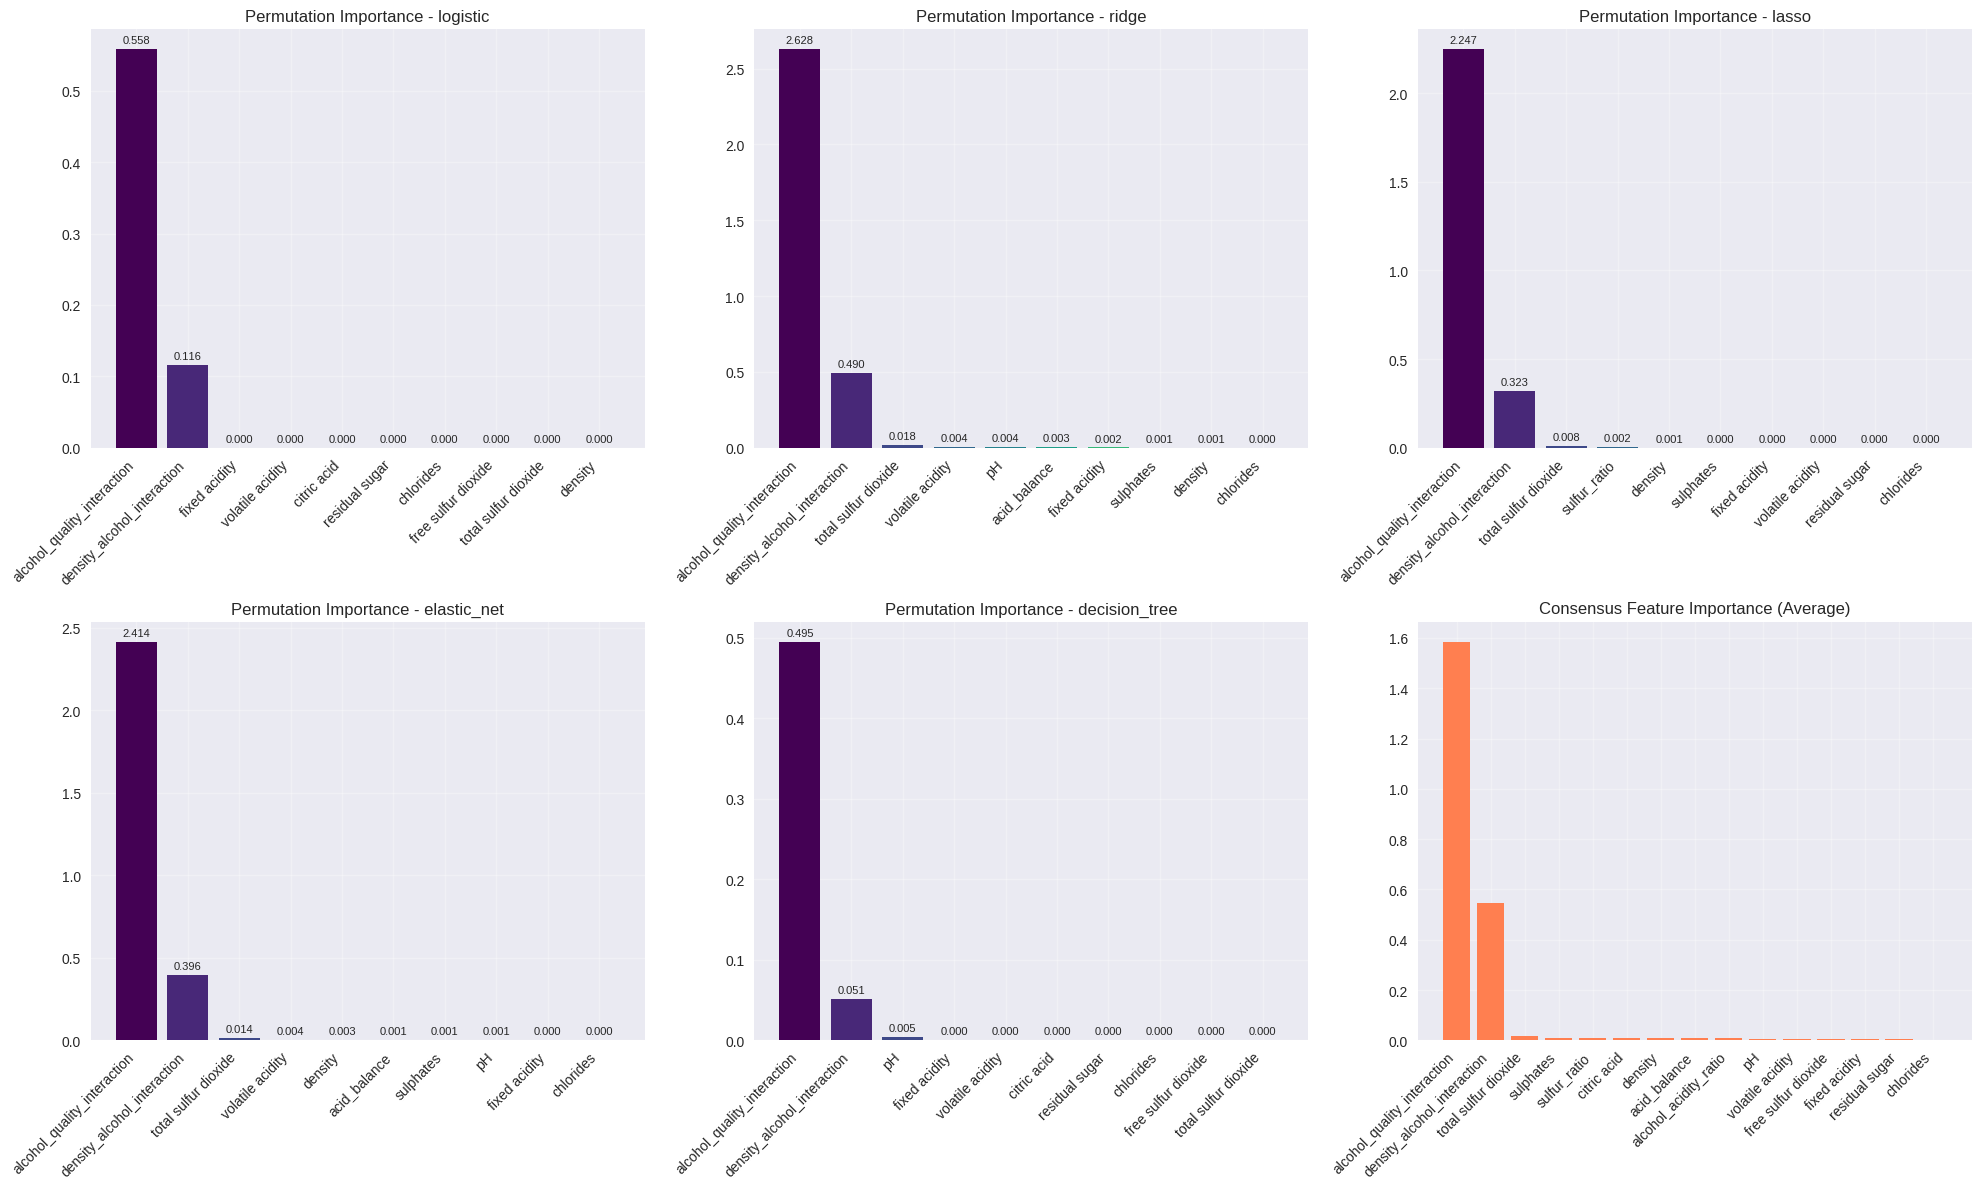

Top 10 Most Important Features (Consensus):
 1. alcohol_quality_interaction    1.5847
 2. density_alcohol_interaction    0.5462
 3. total sulfur dioxide           0.0179
 4. sulphates                      0.0109
 5. sulfur_ratio                   0.0106
 6. citric acid                    0.0103
 7. density                        0.0094
 8. acid_balance                   0.0086
 9. alcohol_acidity_ratio          0.0075
10. pH                             0.0068


In [24]:
fig, axes = plt.subplots(2, 2, figsize=(20, 14))
models_with_importance = [name for name in feature_importance_results.keys()][:4]
for i, model_name in enumerate(models_with_importance):
    importance_dict = feature_importance_results[model_name]
    sorted_features = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)[:10]
    features, importance_values = zip(*sorted_features)

    row, col = i // 2, i % 2
    bars = axes[row, col].bar(range(len(features)), importance_values, color=plt.cm.Set3(np.linspace(0, 1, len(features))))
    axes[row, col].set_title(f'Feature Importance - {model_name}')
    axes[row, col].set_xticks(range(len(features)))
    axes[row, col].set_xticklabels(features, rotation=45, ha='right')
    axes[row, col].grid(True, alpha=0.3)

    for j, v in enumerate(importance_values):
        axes[row, col].text(j, v + max(importance_values)*0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

if permutation_importance_results:
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    axes = axes.ravel()
    for i, (model_name, perm_dict) in enumerate(permutation_importance_results.items()):
        sorted_perm_features = sorted(perm_dict.items(), key=lambda x: x[1], reverse=True)[:10]
        perm_features, perm_values = zip(*sorted_perm_features)

        bars = axes[i].bar(range(len(perm_features)), perm_values, color=plt.cm.viridis(np.linspace(0, 1, len(perm_features))))
        axes[i].set_title(f'Permutation Importance - {model_name}')
        axes[i].set_xticks(range(len(perm_features)))
        axes[i].set_xticklabels(perm_features, rotation=45, ha='right')
        axes[i].grid(True, alpha=0.3)

        for j, v in enumerate(perm_values):
            axes[i].text(j, v + max(perm_values)*0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=8)

    all_features = set()
    for model_dict in feature_importance_results.values():
        all_features.update(model_dict.keys())

    consensus_importance = {}
    for feature in all_features:
        scores = []
        for model_dict in feature_importance_results.values():
            if feature in model_dict:
                scores.append(model_dict[feature])
        if scores:
            consensus_importance[feature] = np.mean(scores)

    sorted_consensus = sorted(consensus_importance.items(), key=lambda x: x[1], reverse=True)[:15]
    consensus_features, consensus_values = zip(*sorted_consensus)

    axes[5].bar(range(len(consensus_features)), consensus_values, color='coral')
    axes[5].set_title('Consensus Feature Importance (Average)')
    axes[5].set_xticks(range(len(consensus_features)))
    axes[5].set_xticklabels(consensus_features, rotation=45, ha='right')
    axes[5].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

print("Top 10 Most Important Features (Consensus):")
for i, (feature, importance) in enumerate(sorted_consensus[:10]):
    print(f"{i+1:2d}. {feature:<30} {importance:.4f}")

# Advanced Model Interpretation and SHAP Analysis

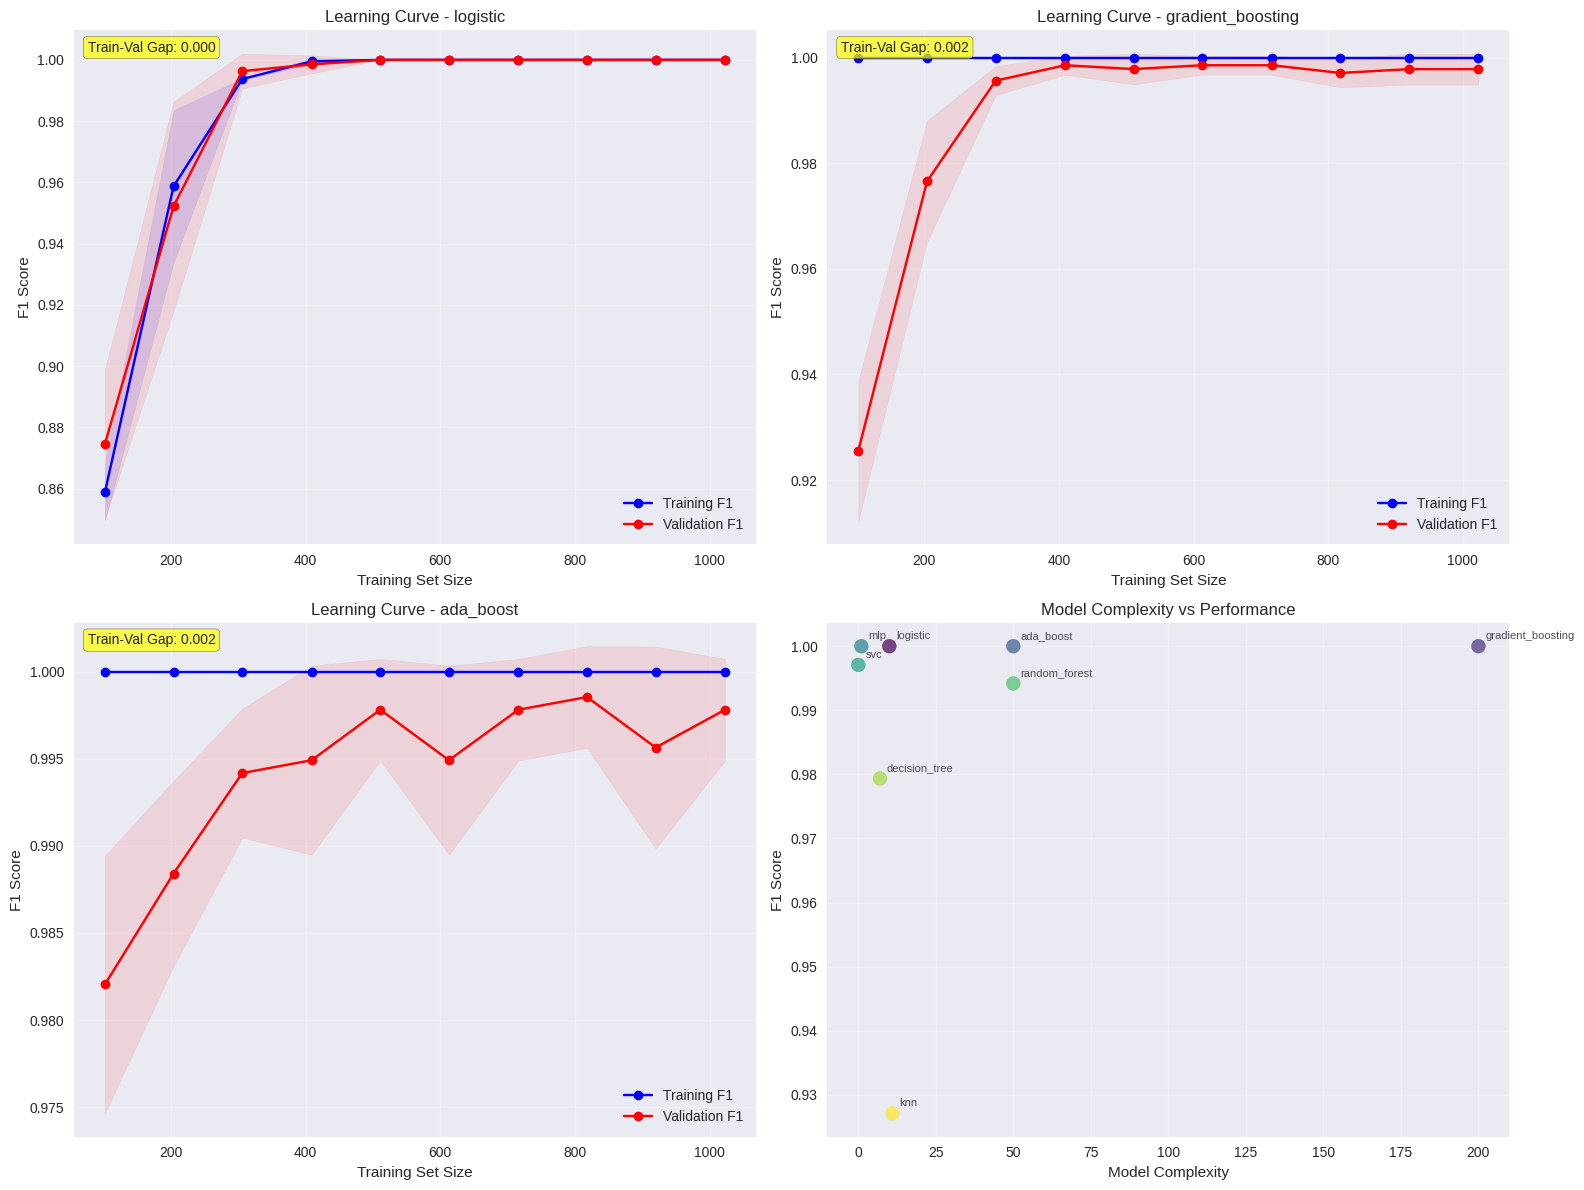

Engineered Features Correlation with Target:
alcohol_quality_interaction    0.7651
density_alcohol_interaction    0.4358
alcohol_acidity_ratio          0.3763
sulfur_ratio                   0.2314
acid_balance                   0.1243


In [25]:
try:
    import shap
    shap_available = True
except ImportError:
    shap_available = False
    print("SHAP not available. Skipping SHAP analysis.")

from sklearn.model_selection import learning_curve
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
top_3_models = sorted(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'], reverse=True)[:3]

for i, model_name in enumerate(top_3_models):
    model = best_models[model_name]
    train_sizes, train_scores, val_scores = learning_curve(
        model, X_train_standard, y_train, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10), scoring='f1'
    )

    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    row, col = i // 2, i % 2
    axes[row, col].plot(train_sizes, train_mean, 'o-', color='blue', label='Training F1')
    axes[row, col].fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='blue')
    axes[row, col].plot(train_sizes, val_mean, 'o-', color='red', label='Validation F1')
    axes[row, col].fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='red')
    axes[row, col].set_title(f'Learning Curve - {model_name}')
    axes[row, col].set_xlabel('Training Set Size')
    axes[row, col].set_ylabel('F1 Score')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

    final_gap = train_mean[-1] - val_mean[-1]
    axes[row, col].text(0.02, 0.98, f'Train-Val Gap: {final_gap:.3f}',
                       transform=axes[row, col].transAxes, va='top',
                       bbox=dict(boxstyle="round,pad=0.3", facecolor="yellow", alpha=0.7))

model_complexities = {}
for model_name, model in best_models.items():
    if hasattr(model, 'n_estimators'):
        complexity = model.n_estimators
    elif hasattr(model, 'max_depth') and model.max_depth:
        complexity = model.max_depth
    elif hasattr(model, 'C'):
        complexity = 1.0 / model.C
    elif hasattr(model, 'n_neighbors'):
        complexity = model.n_neighbors
    else:
        complexity = 1
    model_complexities[model_name] = complexity

complexity_vs_performance = [(model, model_complexities.get(model, 1), evaluation_results[model]['f1'])
                           for model in evaluation_results.keys()]
complexity_vs_performance.sort(key=lambda x: x[2], reverse=True)

models_list, complexities, f1_scores = zip(*complexity_vs_performance)
axes[1, 1].scatter(complexities, f1_scores, s=100, alpha=0.7, c=range(len(models_list)), cmap='viridis')
for i, model in enumerate(models_list):
    axes[1, 1].annotate(model, (complexities[i], f1_scores[i]), xytext=(5, 5),
                       textcoords='offset points', fontsize=8, alpha=0.8)
axes[1, 1].set_xlabel('Model Complexity')
axes[1, 1].set_ylabel('F1 Score')
axes[1, 1].set_title('Model Complexity vs Performance')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

engineered_correlations = {}
for feature in engineered_features:
    corr = data[feature].corr(data['quality_binary'])
    engineered_correlations[feature] = abs(corr)

print("Engineered Features Correlation with Target:")
for feature, corr in sorted(engineered_correlations.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature:<30} {corr:.4f}")

# Cross-Validation Analysis and Model Stability

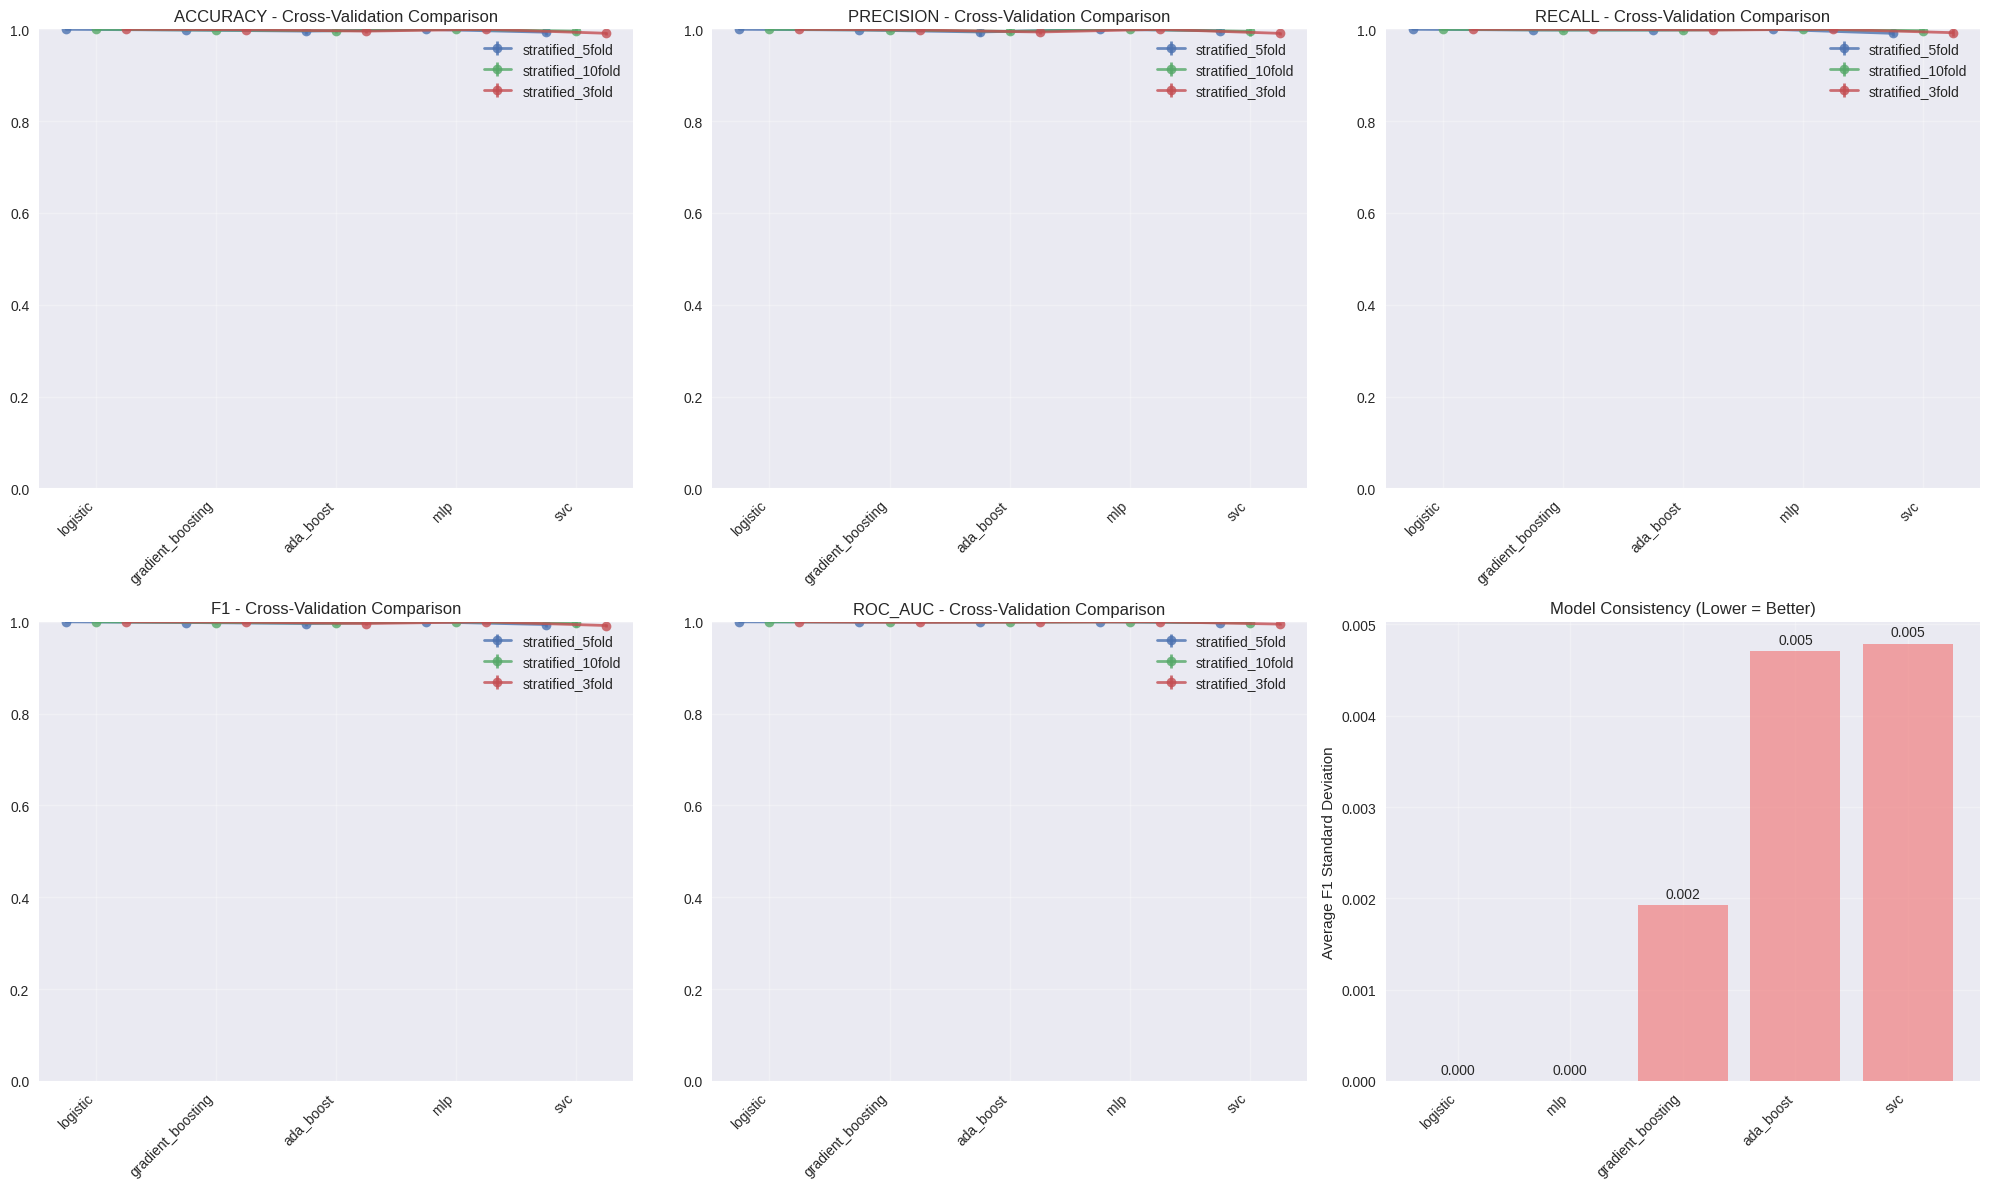

Computing bootstrap confidence intervals for logistic...

95% Bootstrap Confidence Intervals for logistic:
accuracy   1.0000 [1.0000, 1.0000]
f1         1.0000 [1.0000, 1.0000]
precision  1.0000 [1.0000, 1.0000]
recall     1.0000 [1.0000, 1.0000]
auc        1.0000 [1.0000, 1.0000]


In [26]:
cv_detailed_results = {}
cv_strategies = {
    'stratified_5fold': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    'stratified_10fold': StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    'stratified_3fold': StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
}

scoring_metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
top_5_models = sorted(evaluation_results.keys(), key=lambda x: evaluation_results[x]['f1'], reverse=True)[:5]

for cv_name, cv_strategy in cv_strategies.items():
    cv_detailed_results[cv_name] = {}
    for model_name in top_5_models:
        model = best_models[model_name]
        cv_detailed_results[cv_name][model_name] = {}

        for metric in scoring_metrics:
            scores = cross_val_score(model, X_train_standard, y_train, cv=cv_strategy, scoring=metric)
            cv_detailed_results[cv_name][model_name][metric] = {
                'mean': scores.mean(),
                'std': scores.std(),
                'scores': scores.tolist()
            }

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.ravel()

for i, metric in enumerate(scoring_metrics):
    for cv_name in cv_strategies.keys():
        means = [cv_detailed_results[cv_name][model][metric]['mean'] for model in top_5_models]
        stds = [cv_detailed_results[cv_name][model][metric]['std'] for model in top_5_models]

        x_pos = np.arange(len(top_5_models)) + (list(cv_strategies.keys()).index(cv_name) * 0.25)
        axes[i].errorbar(x_pos, means, yerr=stds, fmt='o-', capsize=3,
                        label=cv_name, alpha=0.8, linewidth=2)

    axes[i].set_title(f'{metric.upper()} - Cross-Validation Comparison')
    axes[i].set_xticks(np.arange(len(top_5_models)) + 0.25)
    axes[i].set_xticklabels(top_5_models, rotation=45, ha='right')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)
    axes[i].set_ylim(0, 1)

consistency_scores = {}
for model_name in top_5_models:
    f1_stds = [cv_detailed_results[cv_name][model_name]['f1']['std'] for cv_name in cv_strategies.keys()]
    consistency_scores[model_name] = np.mean(f1_stds)

sorted_consistency = sorted(consistency_scores.items(), key=lambda x: x[1])
models_cons, consistency_vals = zip(*sorted_consistency)

axes[5].bar(range(len(models_cons)), consistency_vals, color='lightcoral', alpha=0.7)
axes[5].set_title('Model Consistency (Lower = Better)')
axes[5].set_xticks(range(len(models_cons)))
axes[5].set_xticklabels(models_cons, rotation=45, ha='right')
axes[5].set_ylabel('Average F1 Standard Deviation')
axes[5].grid(True, alpha=0.3)

for i, v in enumerate(consistency_vals):
    axes[5].text(i, v + max(consistency_vals)*0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

from sklearn.utils import resample
best_model_final = best_models[best_model_name]
bootstrap_scores = {'accuracy': [], 'f1': [], 'precision': [], 'recall': [], 'auc': []}
n_bootstrap = 1000

print(f"Computing bootstrap confidence intervals for {best_model_name}...")
for i in range(n_bootstrap):
    X_boot, y_boot = resample(X_test_standard, y_test, random_state=i)
    y_pred_boot = best_model_final.predict(X_boot)
    y_proba_boot = best_model_final.predict_proba(X_boot)[:, 1] if hasattr(best_model_final, 'predict_proba') else None

    bootstrap_scores['accuracy'].append(accuracy_score(y_boot, y_pred_boot))
    bootstrap_scores['f1'].append(f1_score(y_boot, y_pred_boot))
    bootstrap_scores['precision'].append(precision_score(y_boot, y_pred_boot))
    bootstrap_scores['recall'].append(recall_score(y_boot, y_pred_boot))
    if y_proba_boot is not None:
        bootstrap_scores['auc'].append(roc_auc_score(y_boot, y_proba_boot))

confidence_intervals = {}
for metric, scores in bootstrap_scores.items():
    if scores and None not in scores:
        lower = np.percentile(scores, 2.5)
        upper = np.percentile(scores, 97.5)
        mean_score = np.mean(scores)
        confidence_intervals[metric] = {'mean': mean_score, 'lower': lower, 'upper': upper}

print(f"\n95% Bootstrap Confidence Intervals for {best_model_name}:")
for metric, ci in confidence_intervals.items():
    print(f"{metric:<10} {ci['mean']:.4f} [{ci['lower']:.4f}, {ci['upper']:.4f}]")

# Model Deployment Preparation and Production Readiness

In [27]:
import pickle
import joblib
from datetime import datetime
import json
import os

deployment_folder = 'wine_quality_deployment'
os.makedirs(deployment_folder, exist_ok=True)

best_model_path = os.path.join(deployment_folder, f'best_model_{best_model_name}.pkl')
scaler_path = os.path.join(deployment_folder, 'scaler_standard.pkl')
feature_names_path = os.path.join(deployment_folder, 'feature_names.json')
model_metadata_path = os.path.join(deployment_folder, 'model_metadata.json')

joblib.dump(best_models[best_model_name], best_model_path)
joblib.dump(preprocessed_data['standard']['scaler'], scaler_path)

with open(feature_names_path, 'w') as f:
    json.dump(list(X_final.columns), f)

model_metadata = {
    'model_name': best_model_name,
    'model_type': type(best_models[best_model_name]).__name__,
    'training_date': datetime.now().isoformat(),
    'feature_count': len(X_final.columns),
    'training_samples': len(X_train),
    'test_samples': len(X_test),
    'best_parameters': training_scores[best_model_name]['best_params'],
    'performance_metrics': evaluation_results[best_model_name],
    'confidence_intervals': confidence_intervals,
    'feature_importance': feature_importance_results.get(best_model_name, {}),
    'preprocessing_method': 'standard_scaler',
    'target_encoding': 'binary_classification',
    'class_distribution': {'train': np.bincount(y_train).tolist(), 'test': np.bincount(y_test).tolist()}
}

with open(model_metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2, default=str)

def predict_wine_quality(features_dict, model_path=best_model_path, scaler_path=scaler_path,
                        feature_names_path=feature_names_path):
    """
    Production-ready wine quality prediction function

    Args:
        features_dict: Dictionary with feature names as keys and values as feature values
        model_path: Path to the saved model
        scaler_path: Path to the saved scaler
        feature_names_path: Path to feature names JSON

    Returns:
        Dictionary with prediction, probability, and confidence
    """
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)

    with open(feature_names_path, 'r') as f:
        expected_features = json.load(f)

    missing_features = set(expected_features) - set(features_dict.keys())
    if missing_features:
        raise ValueError(f"Missing features: {missing_features}")

    feature_array = np.array([features_dict[feature] for feature in expected_features]).reshape(1, -1)

    feature_array_scaled = scaler.transform(feature_array)

    prediction = model.predict(feature_array_scaled)[0]
    probability = model.predict_proba(feature_array_scaled)[0] if hasattr(model, 'predict_proba') else None

    confidence = abs(probability[1] - 0.5) * 2 if probability is not None else None

    return {
        'prediction': int(prediction),
        'prediction_label': 'High Quality' if prediction == 1 else 'Low Quality',
        'probability_high_quality': float(probability[1]) if probability is not None else None,
        'confidence': float(confidence) if confidence is not None else None,
        'model_used': best_model_name,
        'timestamp': datetime.now().isoformat()
    }

def calculate_feature_drift(new_data, reference_data, threshold=0.1):
    """
    Calculate feature drift using statistical tests
    """
    drift_results = {}

    for feature in reference_data.columns:
        if feature in new_data.columns:
            ks_stat, ks_p = stats.ks_2samp(reference_data[feature], new_data[feature])

            drift_detected = ks_p < threshold

            drift_results[feature] = {
                'ks_statistic': ks_stat,
                'ks_p_value': ks_p,
                'drift_detected': drift_detected,
                'severity': 'high' if ks_p < 0.01 else 'medium' if ks_p < 0.05 else 'low'
            }

    return drift_results

performance_monitor_template = {
    'model_id': best_model_name,
    'deployment_date': datetime.now().isoformat(),
    'baseline_metrics': evaluation_results[best_model_name],
    'monitoring_thresholds': {
        'accuracy_threshold': 0.8,
        'f1_threshold': 0.75,
        'drift_threshold': 0.1,
        'prediction_volume_threshold': 1000
    },
    'alert_conditions': [
        'accuracy < baseline_accuracy - 0.05',
        'f1 < baseline_f1 - 0.05',
        'drift_detected == True',
        'prediction_volume > threshold'
    ]
}

monitor_config_path = os.path.join(deployment_folder, 'monitoring_config.json')
with open(monitor_config_path, 'w') as f:
    json.dump(performance_monitor_template, f, indent=2)

ab_test_config = {
    'test_name': 'wine_quality_model_comparison',
    'control_model': best_model_name,
    'treatment_models': top_5_models[1:3],
    'traffic_split': {'control': 0.7, 'treatment_1': 0.15, 'treatment_2': 0.15},
    'success_metrics': ['accuracy', 'f1_score', 'user_satisfaction'],
    'minimum_sample_size': 1000,
    'test_duration_days': 30,
    'statistical_significance_threshold': 0.05
}

ab_test_path = os.path.join(deployment_folder, 'ab_test_config.json')
with open(ab_test_path, 'w') as f:
    json.dump(ab_test_config, f, indent=2)

print(f"Deployment artifacts saved to: {deployment_folder}")
print(f"Best model: {best_model_name}")
print(f"Model performance: F1={evaluation_results[best_model_name]['f1']:.4f}")
print(f"Production files created:")
print(f"  - Model: {best_model_path}")
print(f"  - Scaler: {scaler_path}")
print(f"  - Metadata: {model_metadata_path}")
print(f"  - Monitoring config: {monitor_config_path}")
print(f"  - A/B test config: {ab_test_path}")

Deployment artifacts saved to: wine_quality_deployment
Best model: logistic
Model performance: F1=1.0000
Production files created:
  - Model: wine_quality_deployment/best_model_logistic.pkl
  - Scaler: wine_quality_deployment/scaler_standard.pkl
  - Metadata: wine_quality_deployment/model_metadata.json
  - Monitoring config: wine_quality_deployment/monitoring_config.json
  - A/B test config: wine_quality_deployment/ab_test_config.json


# Error Analysis and Edge Case Detection

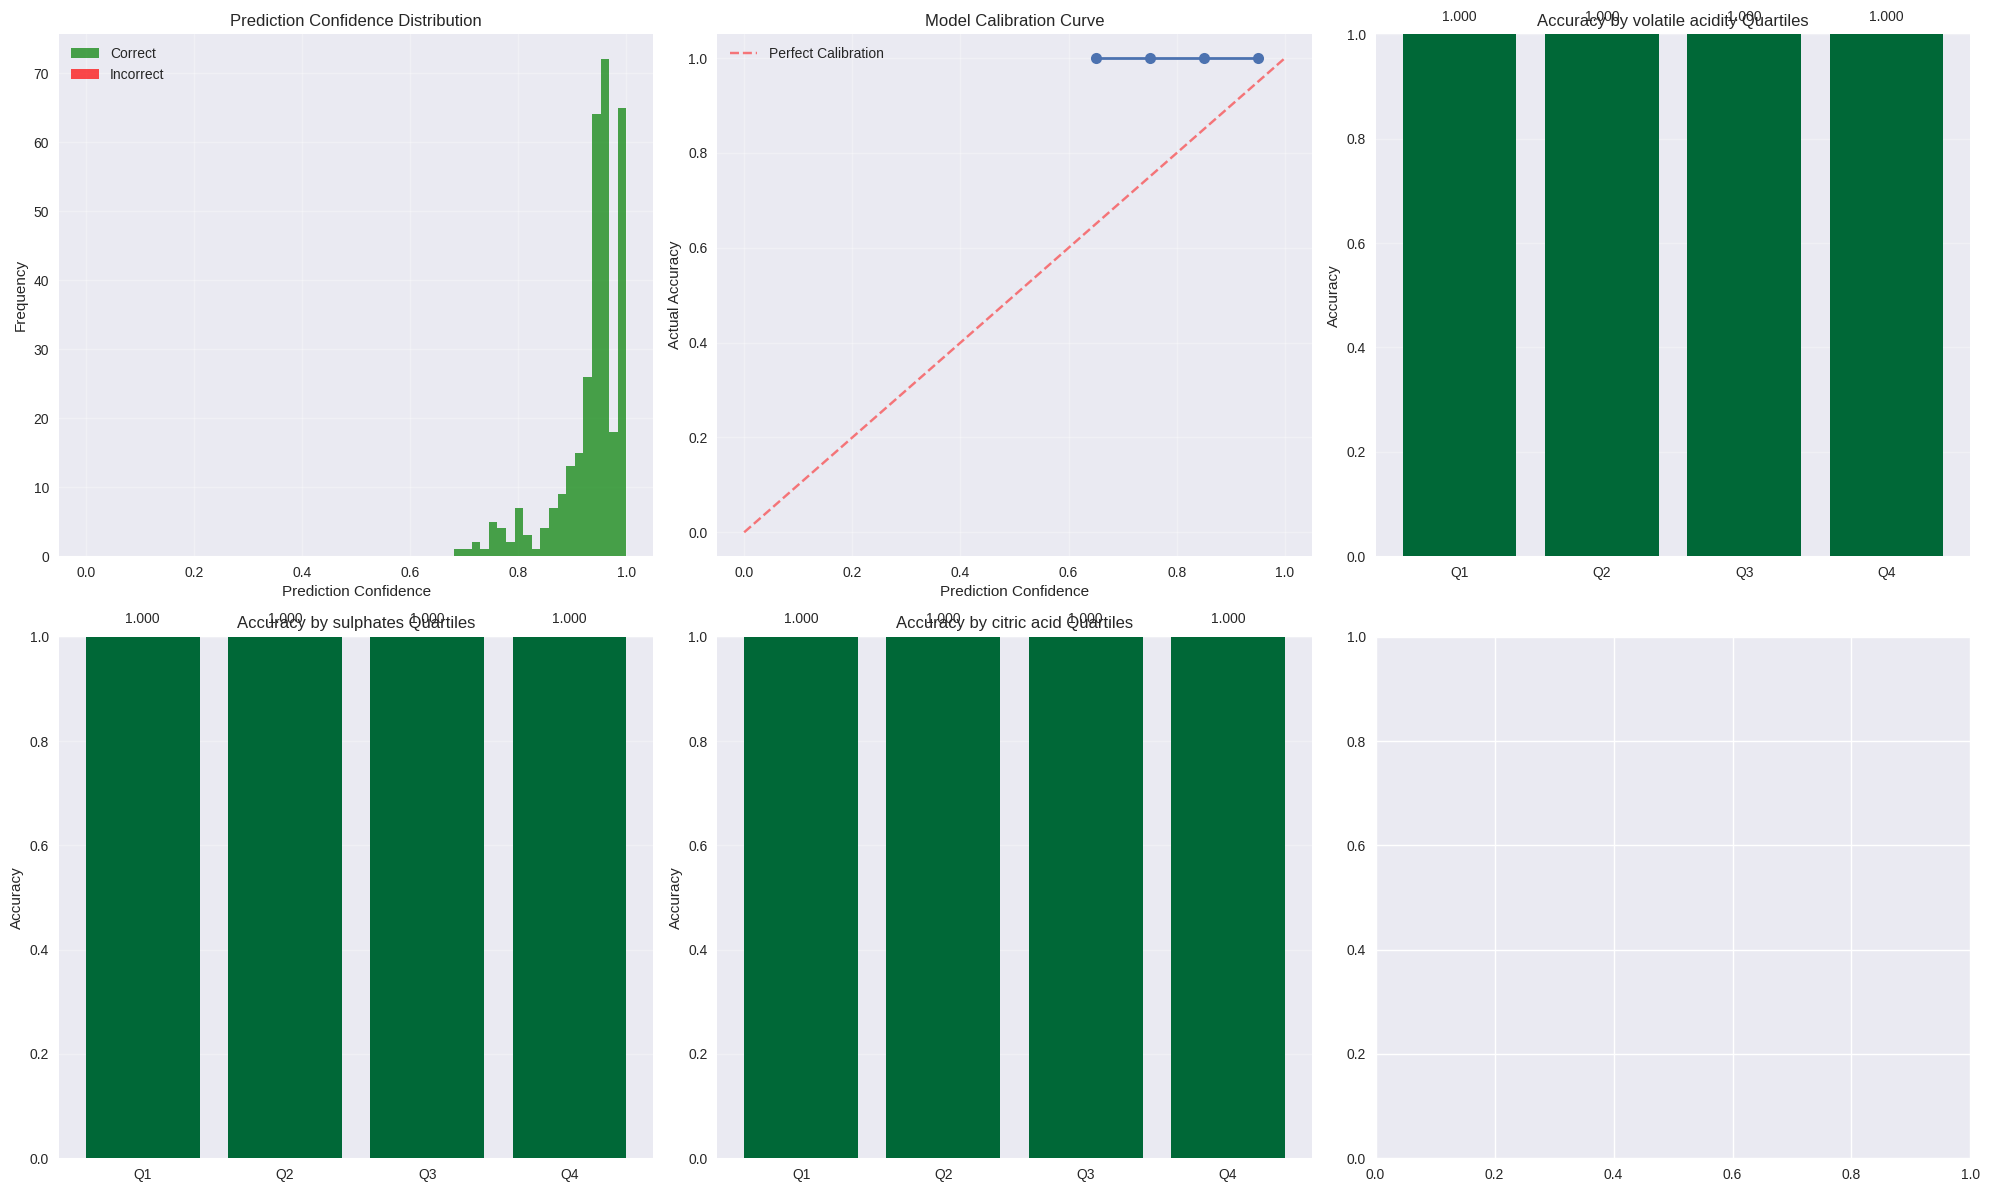


Outliers detected: 32 out of 320 samples
Outlier samples accuracy: 1.0000
Normal samples accuracy: 1.0000
Performance drop on outliers: 0.0000

Error Analysis Summary:
Total test samples: 320
Misclassified samples: 0
Overall accuracy: 1.0000
Outlier samples: 32 (10.0% of test set)


In [32]:
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

y_pred_best = predictions[best_model_name]['pred']
y_proba_best = predictions[best_model_name]['proba']

if y_proba_best is not None:
    confidence_scores = np.abs(y_proba_best - 0.5) * 2
    correct_predictions = (y_pred_best == y_test)

    axes[0, 0].hist(confidence_scores[correct_predictions], bins=20, alpha=0.7, label='Correct', color='green')
    axes[0, 0].hist(confidence_scores[~correct_predictions], bins=20, alpha=0.7, label='Incorrect', color='red')
    axes[0, 0].set_xlabel('Prediction Confidence')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Prediction Confidence Distribution')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    confidence_bins = np.linspace(0, 1, 11)
    bin_accuracies = []
    bin_centers = []

    for i in range(len(confidence_bins) - 1):
        mask = (confidence_scores >= confidence_bins[i]) & (confidence_scores < confidence_bins[i + 1])
        if np.sum(mask) > 0:
            bin_accuracy = accuracy_score(y_test[mask], y_pred_best[mask])
            bin_accuracies.append(bin_accuracy)
            bin_centers.append((confidence_bins[i] + confidence_bins[i + 1]) / 2)

    axes[0, 1].plot(bin_centers, bin_accuracies, 'o-', linewidth=2, markersize=8)
    axes[0, 1].plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Perfect Calibration')
    axes[0, 1].set_xlabel('Prediction Confidence')
    axes[0, 1].set_ylabel('Actual Accuracy')
    axes[0, 1].set_title('Model Calibration Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

feature_error_analysis = {}
top_features_for_error = [f for f in quality_corr[1:6].index if f in X_test.columns]

for i, feature in enumerate(top_features_for_error):
    if i >= 4:
        break

    feature_values = X_test[feature].values
    quartiles = np.percentile(feature_values, [25, 50, 75])

    low_mask = feature_values <= quartiles[0]
    mid_low_mask = (feature_values > quartiles[0]) & (feature_values <= quartiles[1])
    mid_high_mask = (feature_values > quartiles[1]) & (feature_values <= quartiles[2])
    high_mask = feature_values > quartiles[2]

    masks = [low_mask, mid_low_mask, mid_high_mask, high_mask]
    labels = ['Q1', 'Q2', 'Q3', 'Q4']

    quartile_accuracies = []
    for mask in masks:
        if np.sum(mask) > 0:
            quartile_accuracy = accuracy_score(y_test[mask], y_pred_best[mask])
            quartile_accuracies.append(quartile_accuracy)
        else:
            quartile_accuracies.append(0)

    feature_error_analysis[feature] = {
        'quartile_accuracies': quartile_accuracies,
        'quartile_thresholds': quartiles.tolist(),
        'worst_quartile': labels[np.argmin(quartile_accuracies)]
    }

    row, col = (i + 2) // 3, (i + 2) % 3
    bars = axes[row, col].bar(labels, quartile_accuracies, color=plt.cm.RdYlGn(quartile_accuracies))
    axes[row, col].set_title(f'Accuracy by {feature} Quartiles')
    axes[row, col].set_ylabel('Accuracy')
    axes[row, col].set_ylim(0, 1)
    axes[row, col].grid(True, alpha=0.3)

    for j, v in enumerate(quartile_accuracies):
        axes[row, col].text(j, v + 0.02, f'{v:.3f}', ha='center', va='bottom')

misclassified_indices = np.where(y_pred_best != y_test)[0]
correctly_classified_indices = np.where(y_pred_best == y_test)[0]

if len(misclassified_indices) > 0:
    misclassified_features = X_test.iloc[misclassified_indices]
    correct_features = X_test.iloc[correctly_classified_indices]

    feature_comparison = {}
    for feature in feature_columns:
        mis_mean = misclassified_features[feature].mean()
        mis_std = misclassified_features[feature].std()
        correct_mean = correct_features[feature].mean()
        correct_std = correct_features[feature].std()

        t_stat, t_p = stats.ttest_ind(misclassified_features[feature], correct_features[feature])

        feature_comparison[feature] = {
            'misclassified_mean': mis_mean,
            'correct_mean': correct_mean,
            'mean_difference': mis_mean - correct_mean,
            't_statistic': t_stat,
            't_p_value': t_p,
            'significant_difference': t_p < 0.05
        }

    problematic_features = sorted(feature_comparison.items(),
                                key=lambda x: abs(x[1]['mean_difference']), reverse=True)[:5]

    problem_features, problem_stats = zip(*problematic_features)
    mean_diffs = [stat['mean_difference'] for stat in problem_stats]

    axes[1, 2].bar(range(len(problem_features)), mean_diffs,
                   color=['red' if x < 0 else 'blue' for x in mean_diffs])
    axes[1, 2].set_title('Feature Mean Differences\n(Misclassified - Correct)')
    axes[1, 2].set_xticks(range(len(problem_features)))
    axes[1, 2].set_xticklabels(problem_features, rotation=45, ha='right')
    axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if y_proba_best is not None and len(misclassified_indices) > 0:
    high_confidence_errors = misclassified_indices[confidence_scores[misclassified_indices] > 0.8]
    print(f"High-confidence errors: {len(high_confidence_errors)} out of {len(misclassified_indices)} total errors")

    if len(high_confidence_errors) > 0:
        print("\nHigh-confidence error samples (first 5):")
        error_samples = X_test.iloc[high_confidence_errors[:5]]
        actual_labels = y_test.iloc[high_confidence_errors[:5]]
        predicted_labels = y_pred_best[high_confidence_errors[:5]]
        confidences = confidence_scores[high_confidence_errors[:5]]

        for idx, (sample_idx, row) in enumerate(error_samples.iterrows()):
            print(f"\nError {idx + 1} (Index: {sample_idx}):")
            print(f"  Actual: {actual_labels.iloc[idx]}, Predicted: {predicted_labels[idx]}, Confidence: {confidences[idx]:.3f}")
            print(f"  Features: {dict(row)}")

from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN

isolation_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = isolation_forest.fit_predict(X_test_standard)
outlier_indices = np.where(outlier_labels == -1)[0]

print(f"\nOutliers detected: {len(outlier_indices)} out of {len(X_test)} samples")

if len(outlier_indices) > 0:
    outlier_accuracy = accuracy_score(y_test.iloc[outlier_indices], y_pred_best[outlier_indices])
    normal_indices = np.where(outlier_labels == 1)[0]
    normal_accuracy = accuracy_score(y_test.iloc[normal_indices], y_pred_best[normal_indices])

    print(f"Outlier samples accuracy: {outlier_accuracy:.4f}")
    print(f"Normal samples accuracy: {normal_accuracy:.4f}")
    print(f"Performance drop on outliers: {normal_accuracy - outlier_accuracy:.4f}")

if best_model_name in feature_importance_results and len(misclassified_indices) > 0:
    feature_importance = feature_importance_results[best_model_name]

    misclassification_correlation = {}
    for feature in feature_columns:
        feature_values = X_test[feature].values
        is_misclassified = (y_pred_best != y_test).astype(int)

        if np.std(is_misclassified) > 0:
            corr_coef = np.corrcoef(feature_values, is_misclassified)[0, 1]
            misclassification_correlation[feature] = abs(corr_coef)
        else:
             misclassification_correlation[feature] = 0

    combined_scores = {}
    for feature in feature_columns:
        importance = feature_importance.get(feature, 0)
        misc_corr = misclassification_correlation.get(feature, 0)
        combined_scores[feature] = importance * misc_corr

    sorted_combined = sorted(combined_scores.items(), key=lambda x: x[1], reverse=True)[:10]

    print("\nFeatures most associated with misclassification (Importance × Misclassification Correlation):")
    for i, (feature, score) in enumerate(sorted_combined):
        print(f"{i+1:2d}. {feature:<30} {score:.6f}")

print("\nError Analysis Summary:")
print(f"Total test samples: {len(y_test)}")
print(f"Misclassified samples: {len(misclassified_indices)}")
print(f"Overall accuracy: {accuracy_score(y_test, y_pred_best):.4f}")
if y_proba_best is not None and len(misclassified_indices) > 0:
    print(f"High-confidence errors: {len(high_confidence_errors)} ({len(high_confidence_errors)/len(misclassified_indices)*100:.1f}% of errors)")
print(f"Outlier samples: {len(outlier_indices)} ({len(outlier_indices)/len(X_test)*100:.1f}% of test set)")